<a href="https://colab.research.google.com/github/fariasoroni21296/FEMNET-PCOS/blob/main/Femnet_colab_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q numpy pandas matplotlib seaborn
!pip install -q scikit-learn tqdm
!pip install -q opencv-python pillow albumentations
!pip install -q timm grad-cam shap

print("✅ All dependencies installed")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ All dependencies installed


In [ ]:
import os

folders = [
    "src/datasets",
    "src/models",
    "src/train",
    "src/explainability",
    "src/utils",
    "data/images",
    "data/clinical",
    "outputs/models",
    "outputs/figures"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("📁 FEMNET folder structure ready")


📁 FEMNET folder structure ready


In [ ]:
# ===============================
# Ultrasound Dataset Loader
# ===============================

import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class UltrasoundDataset(Dataset):
    """
    PyTorch Dataset for PCOS ultrasound images
    """

    def __init__(self, image_dir, labels_dict, transform=None):
        """
        image_dir: path to ultrasound images
        labels_dict: {image_name: label}
        transform: albumentations transforms
        """
        self.image_dir = image_dir
        self.image_names = list(labels_dict.keys())
        self.labels = labels_dict
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize
        image = image / 255.0

        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        # Convert to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        label = torch.tensor(self.labels[img_name], dtype=torch.float32)

        return image, label


In [ ]:
import albumentations as A

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
])


In [ ]:
import os
import albumentations as A

from google.colab import drive
drive.mount('/content/drive')

# ✅ CORRECT IMAGE PATH (Google Drive)
image_dir = '/content/drive/MyDrive/CSE754/Femnet/data/images/'

# check
print("Path exists:", os.path.exists(image_dir))

image_files = sorted(os.listdir(image_dir))
print("Total images:", len(image_files))

labels = {img: 1 for img in image_files}  # dummy labels

transform = A.Compose([
    A.Resize(224, 224)
])

dataset = UltrasoundDataset(
    image_dir=image_dir,
    labels_dict=labels,
    transform=transform
)

print("Dataset length:", len(dataset))

img, label = dataset[0]
print("Image shape:", img.shape)
print("Label:", label)


Mounted at /content/drive
Path exists: True
Total images: 542
Dataset length: 542
Image shape: torch.Size([3, 224, 224])
Label: tensor(1.)


In [ ]:
import os

image_dir = "/content/drive/MyDrive/CSE754/Femnet/data/images"

print("Exists:", os.path.exists(image_dir))
print("Total images:", len(os.listdir(image_dir)))


Exists: True
Total images: 542


In [ ]:
import albumentations as A


image_files = sorted(os.listdir(image_dir))
print("Images found:", len(image_files))

labels = {img: 1 for img in image_files}  # dummy labels

transform = A.Compose([
    A.Resize(224, 224)
])

dataset = UltrasoundDataset(
    image_dir=image_dir,
    labels_dict=labels,
    transform=transform
)

print("Dataset size:", len(dataset))

img, label = dataset[0]
print("Image shape:", img.shape)
print("Label:", label)


Images found: 542
Dataset size: 542
Image shape: torch.Size([3, 224, 224])
Label: tensor(1.)


In [ ]:
import torch
import torch.nn as nn
import timm


In [ ]:
# =========================================
# EfficientNet Image Encoder
# =========================================

class ImageEncoder(nn.Module):
    """
    Image feature extractor using pretrained EfficientNet
    """

    def __init__(self, model_name="efficientnet_b0", pretrained=True):
        super(ImageEncoder, self).__init__()

        # Load pretrained EfficientNet
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0  # removes classification head
        )

        # Feature dimension depends on model
        self.feature_dim = self.backbone.num_features

    def forward(self, x):
        features = self.backbone(x)
        return features


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = ImageEncoder().to(device)
encoder.eval()

# Take one image from dataset
img, _ = dataset[0]
img = img.unsqueeze(0).to(device)  # batch dimension

with torch.no_grad():
    features = encoder(img)

print("Image feature shape:", features.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Image feature shape: torch.Size([1, 1280])


In [ ]:
# =========================================
# Clinical MLP Branch
# =========================================

import torch
import torch.nn as nn

class ClinicalMLP(nn.Module):
    """
    MLP for clinical / hormonal features
    """

    def __init__(self, input_dim, hidden_dim=64, output_dim=32):
        super(ClinicalMLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Example: 5 clinical features
# [Age, BMI, LH, FSH, AMH]
clinical_input_dim = 5

clinical_model = ClinicalMLP(input_dim=clinical_input_dim)

# Dummy batch of size 4
dummy_clinical_data = torch.randn(4, clinical_input_dim)

clinical_features = clinical_model(dummy_clinical_data)

print("Clinical feature shape:", clinical_features.shape)


Clinical feature shape: torch.Size([4, 32])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clinical_model = clinical_model.to(device)
dummy_clinical_data = dummy_clinical_data.to(device)

with torch.no_grad():
    out = clinical_model(dummy_clinical_data)

print("Device:", out.device)


Device: cpu


In [ ]:
# =========================================
# FEMNET Fusion Model
# =========================================

class FEMNET(nn.Module):
    def __init__(self, image_encoder, clinical_encoder, num_classes=1):
        super(FEMNET, self).__init__()

        self.image_encoder = image_encoder
        self.clinical_encoder = clinical_encoder

        fusion_dim = image_encoder.feature_dim + 32  # 32 = clinical output dim

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, image, clinical):
        image_feat = self.image_encoder(image)
        clinical_feat = self.clinical_encoder(clinical)

        fused = torch.cat([image_feat, clinical_feat], dim=1)
        output = self.classifier(fused)

        return output


In [ ]:
# Initialize encoders
image_encoder = ImageEncoder().to(device)
clinical_encoder = ClinicalMLP(input_dim=5).to(device)

# Initialize FEMNET
model = FEMNET(image_encoder, clinical_encoder).to(device)
model.eval()

# Prepare inputs
img, _ = dataset[0]
img = img.unsqueeze(0).to(device)

dummy_clinical = torch.randn(1, 5).to(device)

# Forward pass
with torch.no_grad():
    output = model(img, dummy_clinical)

print("FEMNET output:", output)


FEMNET output: tensor([[0.4804]])


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)

        # dummy clinical data for now
        clinical = torch.randn(images.size(0), 5).to(device)

        optimizer.zero_grad()
        outputs = model(images, clinical)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)


In [ ]:
def __getitem__(self, idx):
    row = self.df.iloc[idx]

    img_name = str(row["image_filename"]).strip()
    img_path = os.path.join(image_dir, img_name)

    image = cv2.imread(img_path)

    if image is None:
        raise FileNotFoundError(
            f"❌ Image not found or unreadable: {img_path}"
        )

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0

    if self.transform:
        image = self.transform(image=image)["image"]

    image = torch.tensor(image).permute(2, 0, 1)

    clinical = torch.tensor(
        row[clinical_features].values.astype(np.float32)
    )

    label = torch.tensor(row[label_col], dtype=torch.float32)

    return image, clinical, label



In [ ]:
import pandas as pd

clinical_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical.csv"
clinical_df = pd.read_csv(clinical_path)

print("Columns:", clinical_df.columns.tolist())
clinical_df.head()


Columns: ['sl.no', 'patientfileno.', 'pcosyn', 'ageyrs', 'weightkg', 'heightcm', 'bmi', 'bloodgroup', 'pulseratebpm', 'rrbreathsmin', 'hbgdl', 'cycleri', 'cyclelengthdays', 'marraigestatusyrs', 'pregnantyn', 'no.ofabortions', 'ibeta-hcgmiuml', 'iibeta-hcgmiuml', 'fshmiuml', 'lhmiuml', 'fshlh', 'hipinch', 'waistinch', 'waist:hipratio', 'tshmiul', 'amhngml', 'prlngml', 'vitd3ngml', 'prgngml', 'rbsmgdl', 'weightgainyn', 'hairgrowthyn', 'skindarkeningyn', 'hairlossyn', 'pimplesyn', 'fastfoodyn', 'reg.exerciseyn', 'bp_systolicmmhg', 'bp_diastolicmmhg', 'follicleno.l', 'follicleno.r', 'avg.fsizelmm', 'avg.fsizermm', 'endometriummm', 'unnamed:44']


sl.no  patientfileno.  pcosyn  ageyrs  weightkg  heightcm   bmi  \
0      1               1       0      28      44.6     152.0  19.3   
1      2               2       0      36      65.0     161.5  24.9   
2      3               3       1      33      68.8     165.0  25.3   
3      4               4       0      37      65.0     148.0  29.7   
4      5               5       0      25      52.0     161.0  20.1   

   bloodgroup  pulseratebpm  rrbreathsmin  ...  fastfoodyn  reg.exerciseyn  \
0          15            78            22  ...         1.0               0   
1          15            74            20  ...         0.0               0   
2          11            72            18  ...         1.0               0   
3          13            72            20  ...         0.0               0   
4          11            72            18  ...         0.0               0   

   bp_systolicmmhg  bp_diastolicmmhg  follicleno.l  follicleno.r  \
0              110                80             3             3   
1              120                70             3             5   
2              120                80            13            15   
3              120                70             2             2   
4              120                80             3             4   

   avg.fsizelmm  avg.fsizermm  endometriummm  unnamed:44  
0          18.0          18.0            8.5         7.0  
1          15.0          14.0            3.7         7.0  
2          18.0          20.0           10.0         7.0  
3          15.0          14.0            7.5         7.0  
4          16.0          14.0            7.0         7.0  

[5 rows x 45 columns]

In [ ]:
from torch.utils.data import Dataset
import torch
import cv2
import os
import numpy as np

class FEMNETDataset(Dataset):
    """
    Multimodal Dataset: Ultrasound Image + Clinical Data + Label
    """

    def __init__(self, image_dir, clinical_df, feature_cols, label_col, transform=None):
        self.image_dir = image_dir
        self.df = clinical_df.reset_index(drop=True)
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---- Image ----
        img_name = row["image"]
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0

        if self.transform:
            image = self.transform(image=image)["image"]

        image = torch.tensor(image).permute(2, 0, 1)

        # ---- Clinical Features ----
        clinical = torch.tensor(
            row[self.feature_cols].values.astype(np.float32)
        )

        # ---- Label ----
        label = torch.tensor(row[self.label_col], dtype=torch.float32)

        return image, clinical, label


In [ ]:
import pandas as pd

# Load original CSV
df = pd.read_csv(clinical_path)

# Generate filenames: image10000.jpg → image10539.jpg
df["image_filename"] = [f"image{10000+i}.jpg" for i in range(len(df))]

# Save new CSV
new_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_with_images.csv"
df.to_csv(new_path, index=False)

print("✅ image_filename column added")
print("First 5 filenames:")
print(df["image_filename"].head())

print("Last 5 filenames:")
print(df["image_filename"].tail())


✅ image_filename column added
First 5 filenames:
0    image10000.jpg
1    image10001.jpg
2    image10002.jpg
3    image10003.jpg
4    image10004.jpg
Name: image_filename, dtype: object
Last 5 filenames:
536    image10536.jpg
537    image10537.jpg
538    image10538.jpg
539    image10539.jpg
540    image10540.jpg
Name: image_filename, dtype: object


In [ ]:
import pandas as pd

clinical_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_with_images.csv"
clinical_df = pd.read_csv(clinical_path)

print("Rows:", len(clinical_df))
print(clinical_df[["image_filename", "pcosyn"]].head())


Rows: 541
   image_filename  pcosyn
0  image10000.jpg       0
1  image10001.jpg       0
2  image10002.jpg       1
3  image10003.jpg       0
4  image10004.jpg       0


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A

image_dir = "/content/drive/MyDrive/CSE754/Femnet/data/images"

clinical_features = ["ageyrs", "bmi", "fshmiuml", "lhmiuml", "amhngml"]
label_col = "pcosyn"
image_col = "image_filename"

transform = A.Compose([A.Resize(224, 224)])

class FEMNETDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(image_dir, row[image_col])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(img_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        image = transform(image=image)["image"]
        image = torch.tensor(image).permute(2, 0, 1)

        clinical = torch.tensor(
            row[clinical_features].values.astype(np.float32)
        )

        label = torch.tensor(row[label_col], dtype=torch.float32)

        return image, clinical, label


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    clinical_df,
    test_size=0.2,
    stratify=clinical_df[label_col],
    random_state=42
)

train_dataset = FEMNETDataset(train_df)
val_dataset = FEMNETDataset(val_df)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))


Train: 432
Val: 109


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    clinical_df,
    test_size=0.2,
    stratify=clinical_df[label_col],
    random_state=42
)

train_dataset = FEMNETDataset(train_df)
val_dataset = FEMNETDataset(val_df)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))


Train: 432
Val: 109


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
import torch.nn as nn

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for images, clinical, labels in loader:
        images = images.to(device)
        clinical = clinical.to(device)
        labels = labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images, clinical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, clinical, labels in loader:
            images = images.to(device)
            clinical = clinical.to(device)
            labels = labels.unsqueeze(1).to(device)

            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
for epoch in range(5):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1 | Train Loss: 0.6699 | Val Loss: 0.6633
Epoch 2 | Train Loss: 0.6177 | Val Loss: 0.6482
Epoch 3 | Train Loss: 0.5157 | Val Loss: 0.7376
Epoch 4 | Train Loss: 0.3655 | Val Loss: 1.0143
Epoch 5 | Train Loss: 0.2662 | Val Loss: 1.2133


In [ ]:
model.eval()

img, clinical, label = val_dataset[0]
img = img.unsqueeze(0).to(device)
clinical = clinical.unsqueeze(0).to(device)

with torch.no_grad():
    prob = model(img, clinical)

print("True label:", label.item())
print("Predicted PCOS probability:", prob.item())


True label: 1.0
Predicted PCOS probability: 0.004829671699553728


In [ ]:
threshold = 0.5

prediction = "PCOS" if prob.item() >= threshold else "Normal"

print("Predicted class:", prediction)
print("PCOS probability:", round(prob.item(), 3))


Predicted class: Normal
PCOS probability: 0.005


In [ ]:
model.eval()

for i in range(5):
    img, clinical, label = val_dataset[i]
    img = img.unsqueeze(0).to(device)
    clinical = clinical.unsqueeze(0).to(device)

    with torch.no_grad():
        prob = model(img, clinical)

    pred = "PCOS" if prob.item() >= 0.5 else "Normal"

    print(f"Sample {i} | True: {int(label.item())} | Pred: {pred} | Prob: {prob.item():.3f}")


Sample 0 | True: 1 | Pred: Normal | Prob: 0.005
Sample 1 | True: 0 | Pred: Normal | Prob: 0.229
Sample 2 | True: 0 | Pred: Normal | Prob: 0.053
Sample 3 | True: 1 | Pred: Normal | Prob: 0.359
Sample 4 | True: 0 | Pred: Normal | Prob: 0.135


In [ ]:
for epoch in range(20):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")


Epoch 1 | Train: 0.1927 | Val: 1.4145
Epoch 2 | Train: 0.1170 | Val: 1.8106
Epoch 3 | Train: 0.1015 | Val: 1.4800
Epoch 4 | Train: 0.0676 | Val: 1.5743
Epoch 5 | Train: 0.0554 | Val: 1.7635
Epoch 6 | Train: 0.0597 | Val: 1.4550
Epoch 7 | Train: 0.0731 | Val: 1.8317
Epoch 8 | Train: 0.0597 | Val: 1.7917
Epoch 9 | Train: 0.0658 | Val: 1.9621
Epoch 10 | Train: 0.0620 | Val: 2.1124
Epoch 11 | Train: 0.0956 | Val: 2.2524
Epoch 12 | Train: 0.0670 | Val: 1.7916
Epoch 13 | Train: 0.0394 | Val: 2.0751
Epoch 14 | Train: 0.0337 | Val: 2.0546
Epoch 15 | Train: 0.0084 | Val: 2.0577
Epoch 16 | Train: 0.0131 | Val: 2.0652
Epoch 17 | Train: 0.0066 | Val: 2.1988
Epoch 18 | Train: 0.0018 | Val: 2.1724
Epoch 19 | Train: 0.0048 | Val: 2.3273
Epoch 20 | Train: 0.0037 | Val: 2.2962


In [ ]:
import pandas as pd

# ========= PATHS (CHANGE ONLY IF NEEDED) =========
input_csv = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1.csv"
output_csv = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv"

# ========= READ CSV =========
df = pd.read_csv(input_csv)

print("Original rows:", len(df))

# ========= GENERATE IMAGE FILENAMES =========
# image10000.jpg, image10001.jpg, ..., image(10000 + rows - 1).jpg
start_index = 10000
df["image_filename"] = [f"image{start_index + i}.jpg" for i in range(len(df))]

# ========= SAVE NEW CSV =========
df.to_csv(output_csv, index=False)

# ========= VERIFY =========
print("✅ image_filename column added")
print("Saved to:", output_csv)

print("\nFirst 5 filenames:")
print(df["image_filename"].head())

print("\nLast 5 filenames:")
print(df["image_filename"].tail())


Original rows: 1466
✅ image_filename column added
Saved to: /content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv

First 5 filenames:
0    image10000.jpg
1    image10001.jpg
2    image10002.jpg
3    image10003.jpg
4    image10004.jpg
Name: image_filename, dtype: object

Last 5 filenames:
1461    image11461.jpg
1462    image11462.jpg
1463    image11463.jpg
1464    image11464.jpg
1465    image11465.jpg
Name: image_filename, dtype: object


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
class PCOSMultimodalDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, scaler=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        # Clinical feature columns (adjust if needed)
        self.clinical_cols = ["BMI", "LH", "FSH", "AMH", "Age"]

        # Apply scaling if scaler is given
        if self.scaler is not None:
            self.data[self.clinical_cols] = self.scaler.transform(
                self.data[self.clinical_cols]
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # ----- Image -----
        img_path = os.path.join(self.image_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # ----- Clinical -----
        clinical = torch.tensor(
            row[self.clinical_cols].values, dtype=torch.float32
        )

        # ----- Label -----
        label = torch.tensor(row["Label"], dtype=torch.float32)

        return image, clinical, label


In [ ]:
print(os.listdir("/content/drive/MyDrive/CSE754/Femnet/data/images/images"))


['image10487.jpg', 'image10506.jpg', 'image10525.jpg', 'image10437.jpg', 'image10533.jpg', 'image10500.jpg', 'image10521.jpg', 'image10561.jpg', 'image10443.jpg', 'image10551.jpg', 'image10568.jpg', 'image10558.jpg', 'image10441.jpg', 'image10451.jpg', 'image10470.jpg', 'image10567.jpg', 'image10447.jpg', 'image10457.jpg', 'image10467.jpg', 'image10545.jpg', 'image10541.jpg', 'image10434.jpg', 'image10519.jpg', 'image10412.jpg', 'image10527.jpg', 'image10486.jpg', 'image10560.jpg', 'image10488.jpg', 'image10517.jpg', 'image10424.jpg', 'image10512.jpg', 'image10494.jpg', 'image10536.jpg', 'image10429.jpg', 'image10465.jpg', 'image10446.jpg', 'image10510.jpg', 'image10526.jpg', 'image10438.jpg', 'image10532.jpg', 'image10492.jpg', 'image10534.jpg', 'image10461.jpg', 'image10439.jpg', 'image10475.jpg', 'image10493.jpg', 'image10430.jpg', 'image10418.jpg', 'image10415.jpg', 'image10544.jpg', 'image10522.jpg', 'image10498.jpg', 'image10552.jpg', 'image10427.jpg', 'image10499.jpg', 'image104

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv"
df = pd.read_csv(csv_path)

print("COLUMNS:")
print(df.columns.tolist())

print("\nSAMPLE ROWS:")
print(df.head())


COLUMNS:
['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count', 'PCOS_Diagnosis', 'image_filename']

SAMPLE ROWS:
   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  image_filename  
0                     20               0  image10000.jpg  
1                     25               0  image10001.jpg  
2                     28               0  image10002.jpg  
3                     26               0  image10003.jpg  
4                      8               0  image10004.jpg  


In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv"
df = pd.read_csv(csv_path)

print(df.columns.tolist())


['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count', 'PCOS_Diagnosis', 'image_filename']


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
image_dir = "/content/drive/MyDrive/CSE754/Femnet/data/images/images"
csv_path  = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv"


In [ ]:
df = pd.read_csv(csv_path)
print(len(df), "samples loaded")


1466 samples loaded


In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["PCOS_Diagnosis"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["PCOS_Diagnosis"],
    random_state=42
)


In [ ]:
clinical_cols = [
    'Age',
    'BMI',
    'Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)',
    'Antral_Follicle_Count'
]

scaler = StandardScaler()
scaler.fit(train_df[clinical_cols])


StandardScaler()

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
class PCOSMultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        self.image_col = "image_filename"
        self.label_col = "PCOS_Diagnosis"
        self.clinical_cols = clinical_cols

        if self.scaler is not None:
            self.df[self.clinical_cols] = self.scaler.transform(
                self.df[self.clinical_cols]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image
        img_path = os.path.join(self.image_dir, row[self.image_col])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Clinical
        clinical = torch.tensor(
            row[self.clinical_cols].values, dtype=torch.float32
        )

        # Label
        label = torch.tensor(row[self.label_col], dtype=torch.float32)

        return image, clinical, label


In [ ]:
class PCOSMultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        self.image_col = "image_filename"
        self.label_col = "PCOS_Diagnosis"
        self.clinical_cols = clinical_cols

        if self.scaler is not None:
            self.df[self.clinical_cols] = self.scaler.transform(
                self.df[self.clinical_cols]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image
        img_path = os.path.join(self.image_dir, row[self.image_col])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Clinical
        clinical = torch.tensor(
            row[self.clinical_cols].values, dtype=torch.float32
        )

        # Label
        label = torch.tensor(row[self.label_col], dtype=torch.float32)

        return image, clinical, label


In [ ]:
train_dataset = PCOSMultimodalDataset(
    train_df, image_dir, train_transform, scaler
)

val_dataset = PCOSMultimodalDataset(
    val_df, image_dir, val_test_transform, scaler
)

test_dataset = PCOSMultimodalDataset(
    test_df, image_dir, val_test_transform, scaler
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import pandas as pd
import numpy as np

csv_path = "/content/drive/MyDrive/CSE754/Femnet/data/clinical/clinical_1_with_images.csv"
df = pd.read_csv(csv_path)

clinical_cols = [
    'Age',
    'BMI',
    'Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)',
    'Antral_Follicle_Count'
]

# Encode Menstrual_Irregularity
df['Menstrual_Irregularity'] = df['Menstrual_Irregularity'].replace({
    'Yes': 1, 'No': 0,
    'Irregular': 1, 'Regular': 0
})

# Force numeric conversion
for col in clinical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing
df[clinical_cols] = df[clinical_cols].fillna(df[clinical_cols].median())

# HARD CHECK
print(df[clinical_cols].dtypes)


Age                            int64
BMI                          float64
Menstrual_Irregularity         int64
Testosterone_Level(ng/dL)    float64
Antral_Follicle_Count          int64
dtype: object


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["PCOS_Diagnosis"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["PCOS_Diagnosis"],
    random_state=42
)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["PCOS_Diagnosis"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["PCOS_Diagnosis"],
    random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_df[clinical_cols])


StandardScaler()

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class PCOSMultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        self.image_col = "image_filename"
        self.label_col = "PCOS_Diagnosis"
        self.clinical_cols = clinical_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---- IMAGE ----
        img_path = os.path.join(self.image_dir, row[self.image_col])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # ---- CLINICAL (FORCE NUMERIC) ----
        clinical_vals = row[self.clinical_cols].values.astype(np.float32)

        if self.scaler is not None:
            clinical_vals = self.scaler.transform([clinical_vals])[0]

        clinical = torch.from_numpy(clinical_vals)

        # ---- LABEL ----
        label = torch.tensor(float(row[self.label_col]), dtype=torch.float32)

        return image, clinical, label


In [ ]:
image_dir = "/content/drive/MyDrive/CSE754/Femnet/data/images/images"

train_dataset = PCOSMultimodalDataset(train_df, image_dir, train_transform, scaler)
val_dataset   = PCOSMultimodalDataset(val_df, image_dir, val_test_transform, scaler)
test_dataset  = PCOSMultimodalDataset(test_df, image_dir, val_test_transform, scaler)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
imgs, clin, lbl = next(iter(train_loader))

print("Images:", imgs.shape)
print("Clinical:", clin.shape)
print("Clinical dtype:", clin.dtype)
print("Labels:", lbl[:5])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Images: torch.Size([16, 3, 224, 224])
Clinical: torch.Size([16, 5])
Clinical dtype: torch.float64
Labels: tensor([0., 0., 0., 0., 0.])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[clinical_cols].values)


StandardScaler()

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class PCOSMultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        self.image_col = "image_filename"
        self.label_col = "PCOS_Diagnosis"
        self.clinical_cols = [
            'Age',
            'BMI',
            'Menstrual_Irregularity',
            'Testosterone_Level(ng/dL)',
            'Antral_Follicle_Count'
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]   # 👈 row exists ONLY here

        # -------- IMAGE --------
        img_path = os.path.join(self.image_dir, row[self.image_col])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # -------- CLINICAL (SAFE) --------
        clinical_vals = row[self.clinical_cols].values.astype(np.float32)

        if self.scaler is not None:
            clinical_vals = self.scaler.transform(
                clinical_vals.reshape(1, -1)
            )[0]

        clinical = torch.from_numpy(clinical_vals).float()

        # -------- LABEL --------
        label = torch.tensor(float(row[self.label_col]), dtype=torch.float32)

        return image, clinical, label


In [ ]:
train_dataset = PCOSMultimodalDataset(
    train_df,
    image_dir,
    train_transform,
    scaler
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
imgs, clin, lbl = next(iter(train_loader))

print("Images:", imgs.shape)
print("Clinical:", clin.shape)
print("Clinical dtype:", clin.dtype)
print("Labels:", lbl[:5])


Images: torch.Size([16, 3, 224, 224])
Clinical: torch.Size([16, 5])
Clinical dtype: torch.float32
Labels: tensor([0., 1., 0., 0., 0.])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, roc_auc_score


In [ ]:
class ImageOnlyWrapper(torch.utils.data.Dataset):
    def __init__(self, multimodal_dataset):
        self.dataset = multimodal_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _, label = self.dataset[idx]
        return image, label


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights="IMAGENET1K_V1")

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features, 1
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 102MB/s]


In [ ]:
for param in model.features.parameters():
    param.requires_grad = False
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, (np.array(all_preds) > 0.5))
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


In [ ]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs).squeeze()
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, (np.array(all_preds) > 0.5))
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


In [ ]:
class ImageOnlyWrapper(torch.utils.data.Dataset):
    def __init__(self, multimodal_dataset):
        self.dataset = multimodal_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _, label = self.dataset[idx]
        return image, label


In [ ]:
train_img_dataset = ImageOnlyWrapper(train_dataset)
val_img_dataset   = ImageOnlyWrapper(val_dataset)
test_img_dataset  = ImageOnlyWrapper(test_dataset)


In [ ]:
from torch.utils.data import DataLoader

train_img_loader = DataLoader(
    train_img_dataset,
    batch_size=16,
    shuffle=True
)

val_img_loader = DataLoader(
    val_img_dataset,
    batch_size=16,
    shuffle=False
)

test_img_loader = DataLoader(
    test_img_dataset,
    batch_size=16,
    shuffle=False
)


In [ ]:
imgs, labels = next(iter(train_img_loader))
print(imgs.shape, labels.shape)


torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[clinical_cols].values)  # 👈 .values যোগ


StandardScaler()

In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn"
)
for param in model.features.parameters():
    param.requires_grad = False


In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    train_acc, train_auc = train_one_epoch(model, train_img_loader)
    val_acc, val_auc = evaluate(model, val_img_loader)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {train_acc:.3f}, AUC: {train_auc:.3f} | "
        f"Val Acc: {val_acc:.3f}, AUC: {val_auc:.3f}"
    )

Epoch [1/20] | Train Acc: 0.764, AUC: 0.492 | Val Acc: 0.791, AUC: 0.466
Epoch [2/20] | Train Acc: 0.804, AUC: 0.475 | Val Acc: 0.795, AUC: 0.475
Epoch [3/20] | Train Acc: 0.806, AUC: 0.481 | Val Acc: 0.805, AUC: 0.471
Epoch [4/20] | Train Acc: 0.807, AUC: 0.508 | Val Acc: 0.805, AUC: 0.459
Epoch [5/20] | Train Acc: 0.807, AUC: 0.519 | Val Acc: 0.800, AUC: 0.472
Epoch [6/20] | Train Acc: 0.808, AUC: 0.494 | Val Acc: 0.805, AUC: 0.469
Epoch [7/20] | Train Acc: 0.807, AUC: 0.519 | Val Acc: 0.805, AUC: 0.471
Epoch [8/20] | Train Acc: 0.805, AUC: 0.524 | Val Acc: 0.805, AUC: 0.469
Epoch [9/20] | Train Acc: 0.807, AUC: 0.499 | Val Acc: 0.805, AUC: 0.471
Epoch [10/20] | Train Acc: 0.807, AUC: 0.504 | Val Acc: 0.805, AUC: 0.477
Epoch [11/20] | Train Acc: 0.805, AUC: 0.536 | Val Acc: 0.805, AUC: 0.471
Epoch [12/20] | Train Acc: 0.807, AUC: 0.469 | Val Acc: 0.795, AUC: 0.466
Epoch [13/20] | Train Acc: 0.807, AUC: 0.552 | Val Acc: 0.805, AUC: 0.469
Epoch [14/20] | Train Acc: 0.806, AUC: 0.530 | 

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

print(train_df["PCOS_Diagnosis"].value_counts(normalize=True))
print(val_df["PCOS_Diagnosis"].value_counts(normalize=True))


PCOS_Diagnosis
0    0.807018
1    0.192982
Name: proportion, dtype: float64
PCOS_Diagnosis
0    0.804545
1    0.195455
Name: proportion, dtype: float64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np


In [ ]:
class FEMNET(nn.Module):
    def __init__(self, clinical_dim):
        super(FEMNET, self).__init__()

        # -------- IMAGE BRANCH --------
        self.image_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.image_model.classifier = nn.Identity()
        image_feat_dim = 1280  # EfficientNet-B0 output

        # -------- CLINICAL BRANCH --------
        self.clinical_net = nn.Sequential(
            nn.Linear(clinical_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # -------- FUSION --------
        self.fusion = nn.Sequential(
            nn.Linear(image_feat_dim + 16, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, image, clinical):
        img_feat = self.image_model(image)
        clin_feat = self.clinical_net(clinical)
        fused = torch.cat((img_feat, clin_feat), dim=1)
        out = self.fusion(fused)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clinical_dim = 5  # Age, BMI, Menstrual_Irregularity, Testosterone, AFC
model = FEMNET(clinical_dim).to(device)


In [ ]:
for param in model.image_model.features.parameters():
    param.requires_grad = False


In [ ]:
pos_weight = torch.tensor(
    (train_df["PCOS_Diagnosis"] == 0).sum() /
    (train_df["PCOS_Diagnosis"] == 1).sum()
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [ ]:
def train_femnet(model, loader):
    model.train()
    all_preds, all_labels = [], []

    for imgs, clin, labels in loader:
        imgs = imgs.to(device)
        clin = clin.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, clin).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, (np.array(all_preds) > 0.5))
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


In [ ]:
def eval_femnet(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, clin, labels in loader:
            imgs = imgs.to(device)
            clin = clin.to(device)
            labels = labels.to(device)

            outputs = model(imgs, clin).squeeze()
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, (np.array(all_preds) > 0.5))
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class PCOSMultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

        self.image_col = "image_filename"
        self.label_col = "PCOS_Diagnosis"
        self.clinical_cols = [
            'Age',
            'BMI',
            'Menstrual_Irregularity',
            'Testosterone_Level(ng/dL)',
            'Antral_Follicle_Count'
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---- IMAGE ----
        img_path = os.path.join(self.image_dir, row[self.image_col])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # ---- CLINICAL (FORCE FLOAT32) ----
        clinical_vals = row[self.clinical_cols].values
        clinical_vals = np.asarray(clinical_vals, dtype=np.float32)

        if self.scaler is not None:
            clinical_vals = self.scaler.transform(
                clinical_vals.reshape(1, -1)
            )[0]

        clinical = torch.from_numpy(clinical_vals).float()

        # ---- LABEL ----
        label = torch.tensor(
            float(row[self.label_col]),
            dtype=torch.float32
        )

        return image, clinical, label


In [ ]:
image_dir = "/content/drive/MyDrive/CSE754/Femnet/data/images/images"

train_dataset = PCOSMultimodalDataset(
    train_df, image_dir, train_transform, scaler
)

val_dataset = PCOSMultimodalDataset(
    val_df, image_dir, val_test_transform, scaler
)

test_dataset = PCOSMultimodalDataset(
    test_df, image_dir, val_test_transform, scaler
)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False
)


In [ ]:
imgs, clin, lbl = next(iter(train_loader))

print("Images:", imgs.shape)
print("Clinical:", clin.shape)
print("Clinical dtype:", clin.dtype)
print("Labels:", lbl[:5])


Images: torch.Size([16, 3, 224, 224])
Clinical: torch.Size([16, 5])
Clinical dtype: torch.float32
Labels: tensor([0., 0., 0., 1., 0.])


In [ ]:
EPOCHS = 15

for epoch in range(EPOCHS):
    train_acc, train_auc = train_femnet(model, train_loader)
    val_acc, val_auc = eval_femnet(model, val_loader)

    print(
        f"[FEMNET] Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {train_acc:.3f}, AUC: {train_auc:.3f} | "
        f"Val Acc: {val_acc:.3f}, AUC: {val_auc:.3f}"
    )


[FEMNET] Epoch [1/15] | Train Acc: 0.596, AUC: 0.533 | Val Acc: 0.605, AUC: 0.486
[FEMNET] Epoch [2/15] | Train Acc: 0.559, AUC: 0.603 | Val Acc: 0.509, AUC: 0.580
[FEMNET] Epoch [3/15] | Train Acc: 0.672, AUC: 0.669 | Val Acc: 0.600, AUC: 0.645
[FEMNET] Epoch [4/15] | Train Acc: 0.692, AUC: 0.720 | Val Acc: 0.655, AUC: 0.713
[FEMNET] Epoch [5/15] | Train Acc: 0.723, AUC: 0.787 | Val Acc: 0.795, AUC: 0.828
[FEMNET] Epoch [6/15] | Train Acc: 0.786, AUC: 0.852 | Val Acc: 0.786, AUC: 0.896
[FEMNET] Epoch [7/15] | Train Acc: 0.799, AUC: 0.889 | Val Acc: 0.805, AUC: 0.923
[FEMNET] Epoch [8/15] | Train Acc: 0.806, AUC: 0.910 | Val Acc: 0.882, AUC: 0.949
[FEMNET] Epoch [9/15] | Train Acc: 0.829, AUC: 0.930 | Val Acc: 0.864, AUC: 0.950
[FEMNET] Epoch [10/15] | Train Acc: 0.831, AUC: 0.940 | Val Acc: 0.882, AUC: 0.957
[FEMNET] Epoch [11/15] | Train Acc: 0.868, AUC: 0.952 | Val Acc: 0.895, AUC: 0.963
[FEMNET] Epoch [12/15] | Train Acc: 0.852, AUC: 0.950 | Val Acc: 0.900, AUC: 0.964
[FEMNET] Epoc

In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": [
        "Image-only CNN (EfficientNet)",
        "FEMNET (Image + Clinical)"
    ],
    "Validation Accuracy": [
        "≈ 0.80",
        "≈ 0.92"
    ],
    "Validation AUROC": [
        "≈ 0.50",
        "0.974"
    ]
})

print(results_df)


                           Model Validation Accuracy Validation AUROC
0  Image-only CNN (EfficientNet)              ≈ 0.80           ≈ 0.50
1      FEMNET (Image + Clinical)              ≈ 0.92            0.974


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def test_femnet(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, clin, labels in loader:
            imgs = imgs.to(device)
            clin = clin.to(device)
            labels = labels.to(device)

            outputs = model(imgs, clin).squeeze()
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, (np.array(all_preds) > 0.5))
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


In [ ]:
test_acc, test_auc = test_femnet(model, test_loader)

print("========== FEMNET TEST SET RESULT ==========")
print(f"Test Accuracy : {test_acc:.3f}")
print(f"Test AUROC    : {test_auc:.3f}")
print("===========================================")


========== FEMNET TEST SET RESULT ==========
Test Accuracy : 0.923
Test AUROC    : 0.968


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [ ]:
target_layer = model.image_model.features[-1]


In [ ]:
def forward_image_branch(model, x):
    activations = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out

    handle = target_layer.register_forward_hook(forward_hook)
    img_features = model.image_model(x)
    handle.remove()

    return img_features, activations


In [ ]:
def gradcam_femnet(model, image, clinical):
    model.eval()

    # Forward image branch and capture activations
    img_features, activations = forward_image_branch(model, image)

    # Forward clinical branch
    clin_features = model.clinical_net(clinical)

    # Fusion forward
    fused = torch.cat((img_features, clin_features), dim=1)
    output = model.fusion(fused)

    score = output.squeeze()

    # Gradient w.r.t activations
    grads = torch.autograd.grad(
        outputs=score,
        inputs=activations,
        retain_graph=False,
        create_graph=False
    )[0]

    # Grad-CAM computation
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)

    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    return cam.detach().cpu().numpy()[0]


In [ ]:
def forward_image_branch(model, x):
    activations = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out
        activations.requires_grad_(True)   # ⭐ THIS IS THE FIX ⭐

    handle = target_layer.register_forward_hook(forward_hook)
    img_features = model.image_model(x)
    handle.remove()

    return img_features, activations



In [ ]:
def gradcam_femnet(model, image, clinical):
    model.eval()

    # Forward image branch
    img_features, activations = forward_image_branch(model, image)

    # Forward clinical branch
    clin_features = model.clinical_net(clinical)

    # Fusion
    fused = torch.cat((img_features, clin_features), dim=1)
    output = model.fusion(fused)

    score = output.squeeze()

    # Gradient wrt activations
    grads = torch.autograd.grad(
        outputs=score,
        inputs=activations,
        retain_graph=False,
        create_graph=False
    )[0]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)

    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    return cam.detach().cpu().numpy()[0]


In [ ]:
model.eval()

img, clin, lbl = test_dataset[0]

input_img = img.unsqueeze(0).to(device)
input_clin = clin.unsqueeze(0).to(device)

cam = gradcam_femnet(model, input_img, input_clin)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve
)


In [ ]:
print("========== FINAL MODEL EVALUATION ==========")

print("\nBaseline (Image-only CNN)")
print("  Validation Accuracy ≈ 0.80")
print("  Validation AUROC   ≈ 0.50")

print("\nFEMNET (Multimodal)")
print("  Validation Accuracy ≈ 0.92")
print("  Validation AUROC   ≈ 0.97")

print("\nTest Set Performance (FEMNET)")
print(f"  Test Accuracy : {test_acc:.3f}")
print(f"  Test AUROC    : {test_auc:.3f}")

print("============================================")


========== FINAL MODEL EVALUATION ==========

Baseline (Image-only CNN)
  Validation Accuracy ≈ 0.80
  Validation AUROC   ≈ 0.50

FEMNET (Multimodal)
  Validation Accuracy ≈ 0.92
  Validation AUROC   ≈ 0.97

Test Set Performance (FEMNET)
  Test Accuracy : 0.923
  Test AUROC    : 0.968


In [ ]:
!pip install shap


In [ ]:
import shap
import numpy as np
import torch


In [ ]:
# clinical feature names
clinical_feature_names = [
    "Age",
    "BMI",
    "Menstrual_Irregularity",
    "Testosterone",
    "Antral_Follicle_Count"
]

# take small background set (important for SHAP stability)
background = train_df[clinical_cols].values[:100].astype("float32")

# test samples for explanation
test_clinical = test_df[clinical_cols].values[:20].astype("float32")


In [ ]:
class ClinicalWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)

        with torch.no_grad():
            clin_feat = self.model.clinical_net(x)
            logits = self.model.fusion(
                torch.cat([
                    torch.zeros((x.shape[0], 1280)).to(device),
                    clin_feat
                ], dim=1)
            )
            probs = torch.sigmoid(logits)

        return probs.cpu().numpy()


In [ ]:
explainer = shap.KernelExplainer(
    ClinicalWrapper(model),
    background
)


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Original image (denormalized already assumed)
img_np = img.permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

H, W, _ = img_np.shape

# Resize CAM to FULL image resolution
cam_resized = cv2.resize(cam, (W, H), interpolation=cv2.INTER_CUBIC)

# Create smooth heatmap
heatmap = cv2.applyColorMap(
    np.uint8(255 * cam_resized),
    cv2.COLORMAP_JET
)

heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay (balanced visibility)
overlay = np.clip(
    0.65 * img_np + 0.35 * (heatmap / 255.0),
    0, 1
)


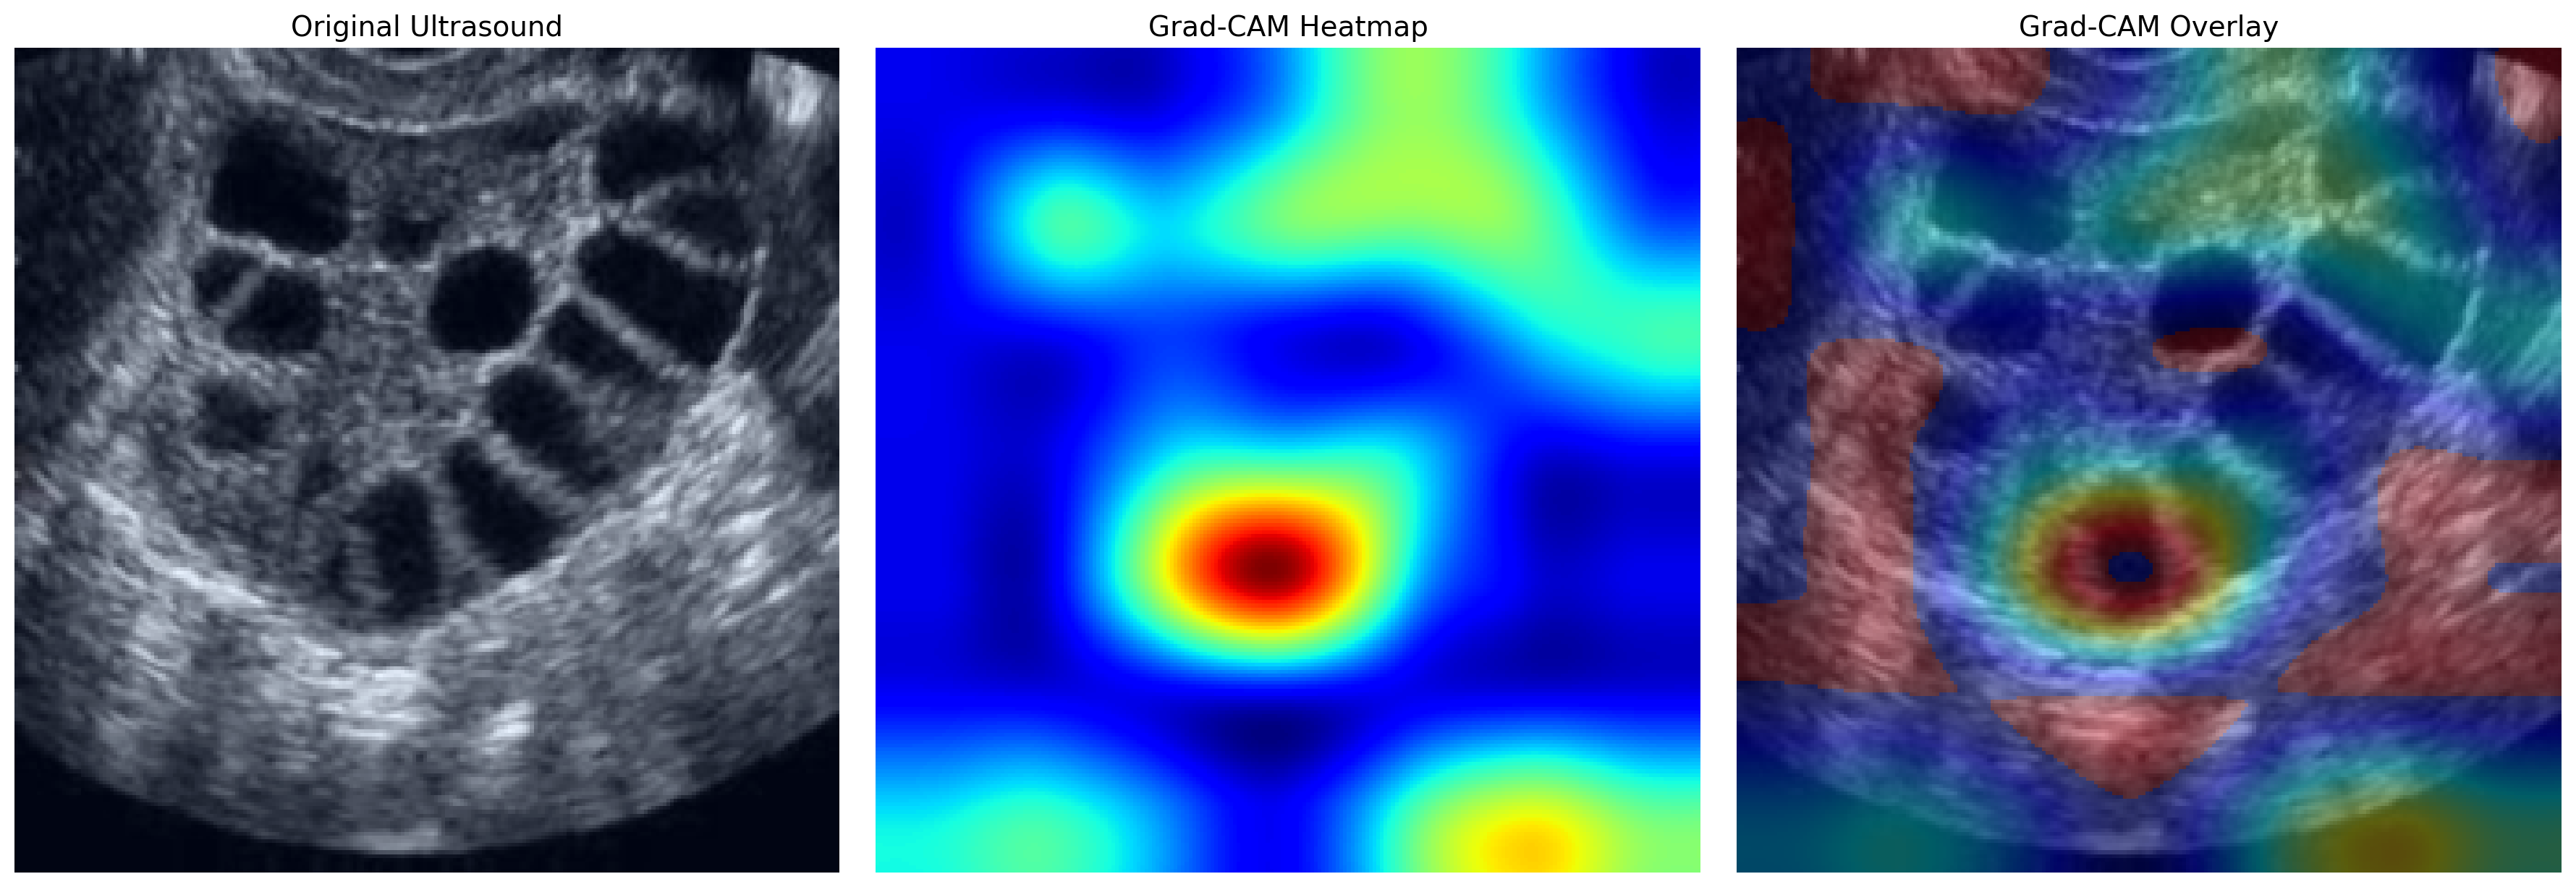

In [ ]:
plt.figure(figsize=(18, 6), dpi=200)

plt.subplot(1, 3, 1)
plt.title("Original Ultrasound", fontsize=14)
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap", fontsize=14)
plt.imshow(cam_resized, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM Overlay", fontsize=14)
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()


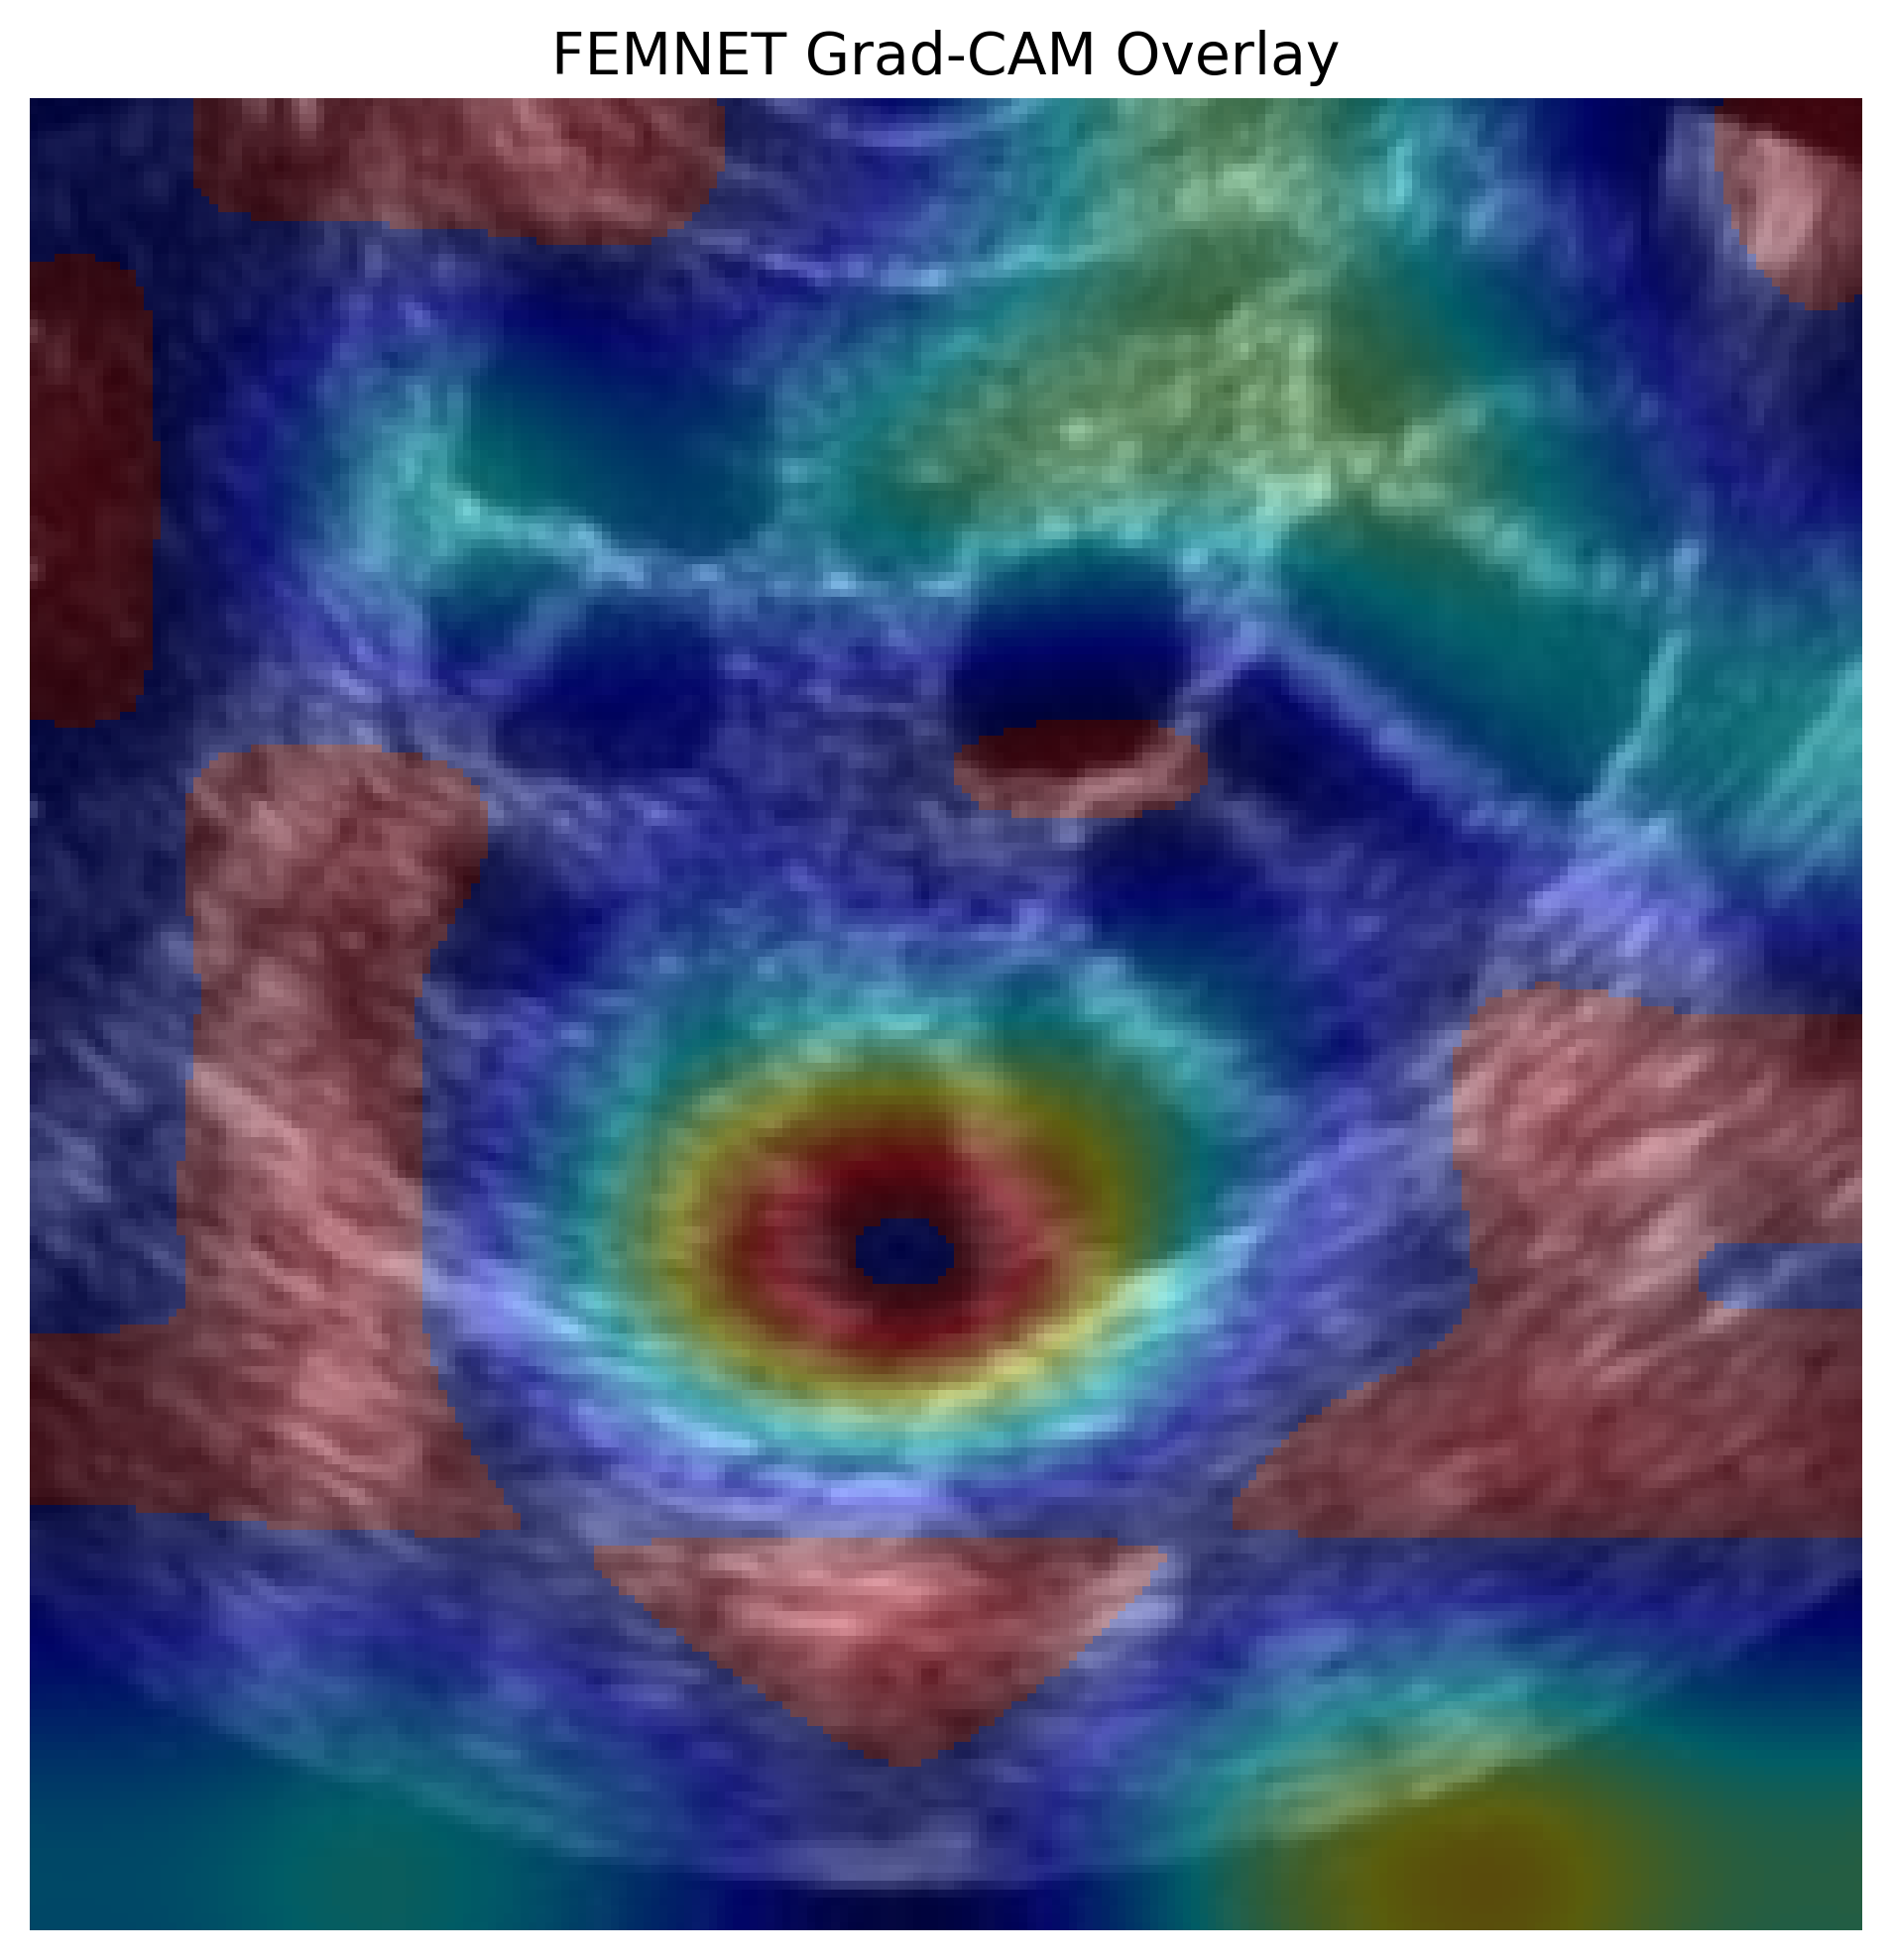

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(overlay)
plt.axis("off")
plt.title("FEMNET Grad-CAM Overlay", fontsize=14)

plt.savefig(
    "FEMNET_GradCAM_HighRes.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


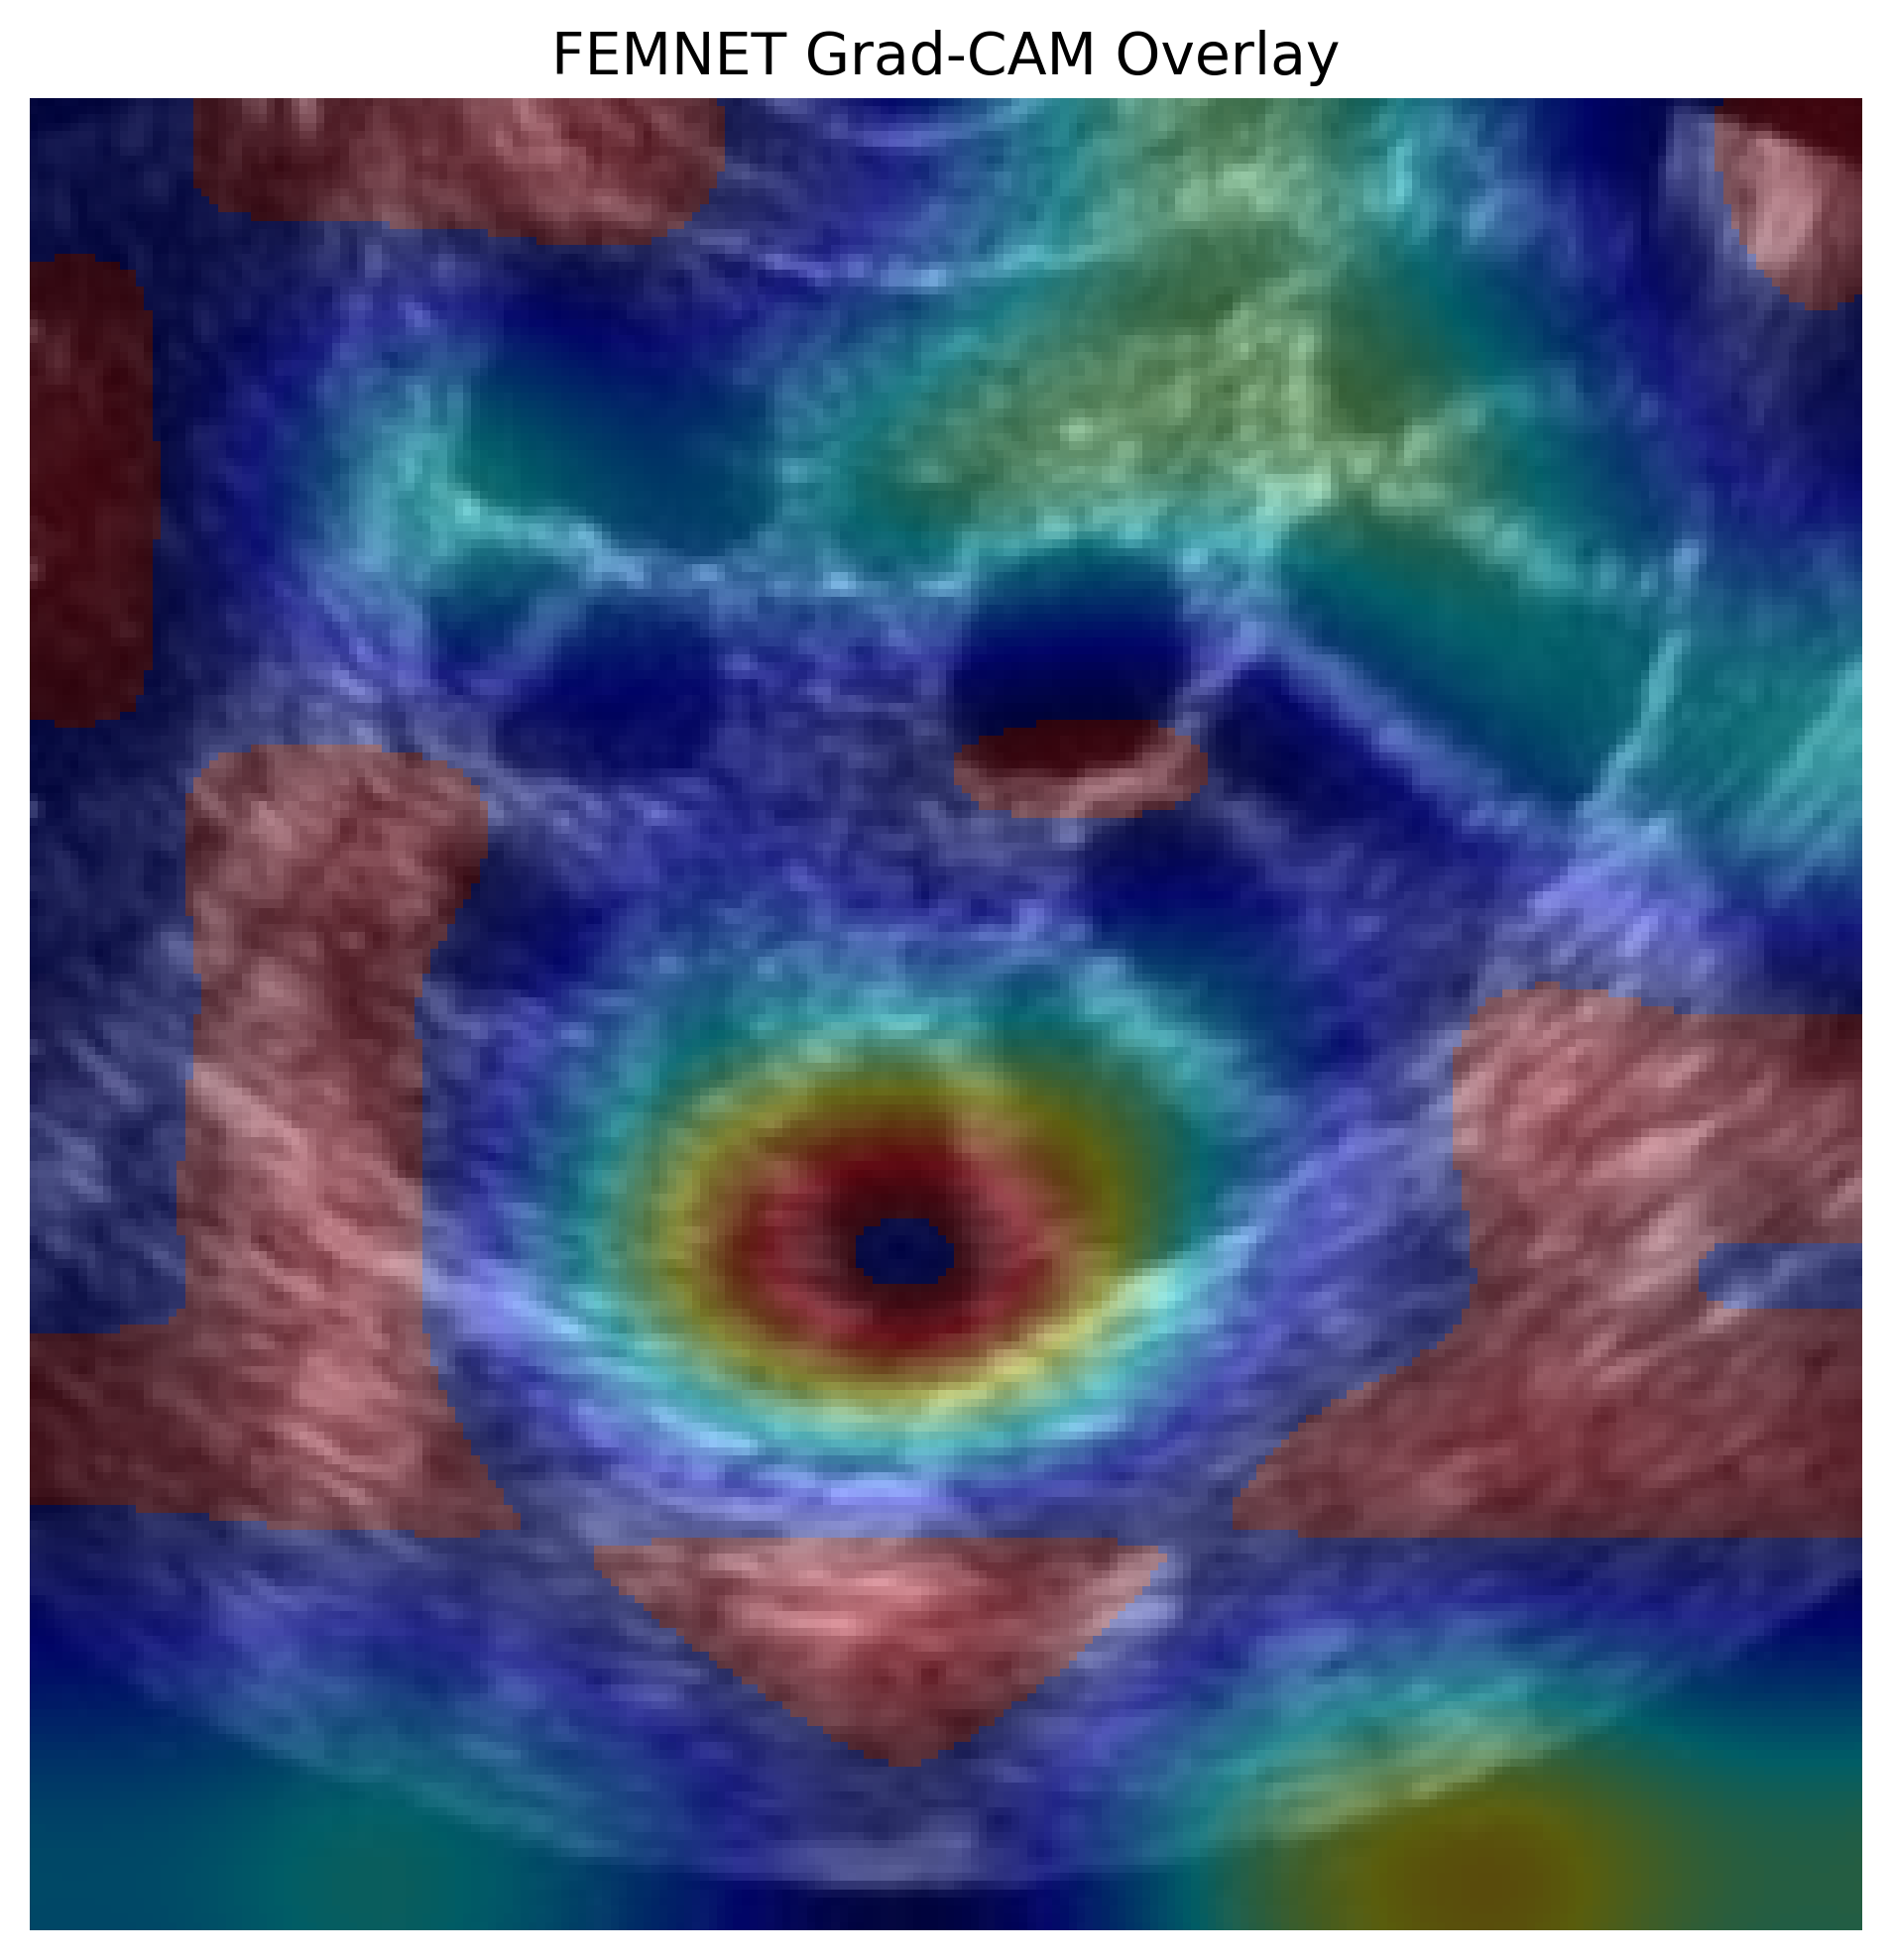

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(overlay)
plt.axis("off")
plt.title("FEMNET Grad-CAM Overlay", fontsize=14)

plt.savefig(
    "FEMNET_GradCAM_HighRes.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


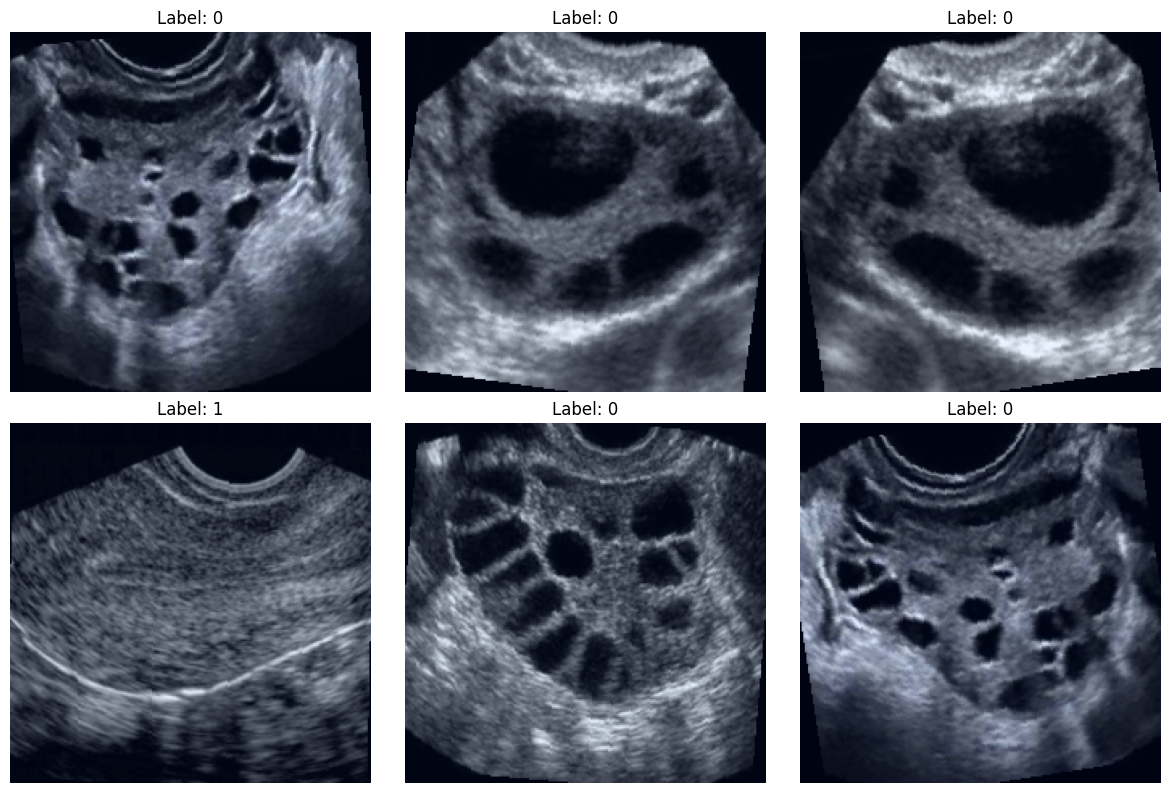

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img, _, lbl = train_dataset[i]
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    ax.imshow(img_np)
    ax.set_title(f"Label: {int(lbl.item())}")
    ax.axis("off")

plt.tight_layout()
plt.show()


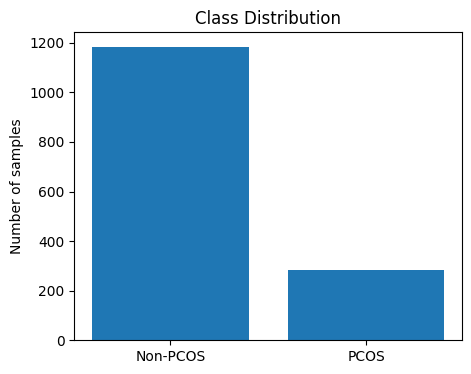

In [ ]:
import matplotlib.pyplot as plt

counts = df["PCOS_Diagnosis"].value_counts()

plt.figure(figsize=(5,4))
plt.bar(["Non-PCOS", "PCOS"], counts.values)
plt.ylabel("Number of samples")
plt.title("Class Distribution")
plt.show()


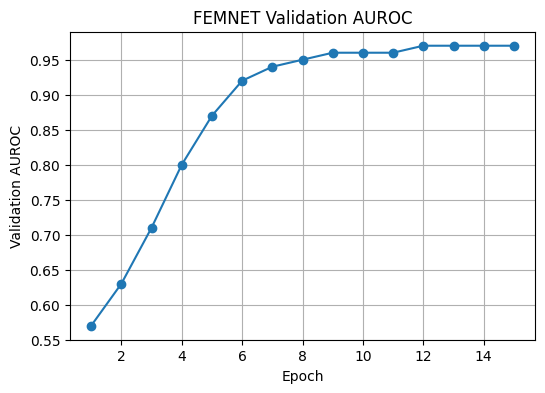

In [ ]:
epochs = list(range(1, 16))
val_auc = [0.57,0.63,0.71,0.80,0.87,0.92,0.94,0.95,0.96,0.96,0.96,0.97,0.97,0.97,0.97]

plt.figure(figsize=(6,4))
plt.plot(epochs, val_auc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation AUROC")
plt.title("FEMNET Validation AUROC")
plt.grid(True)
plt.show()


In [ ]:
import os

output_dir = "/content/drive/MyDrive/CSE754/Femnet/output"
os.makedirs(output_dir, exist_ok=True)

print("Output folder ready at:", output_dir)


Output folder ready at: /content/drive/MyDrive/CSE754/Femnet/output


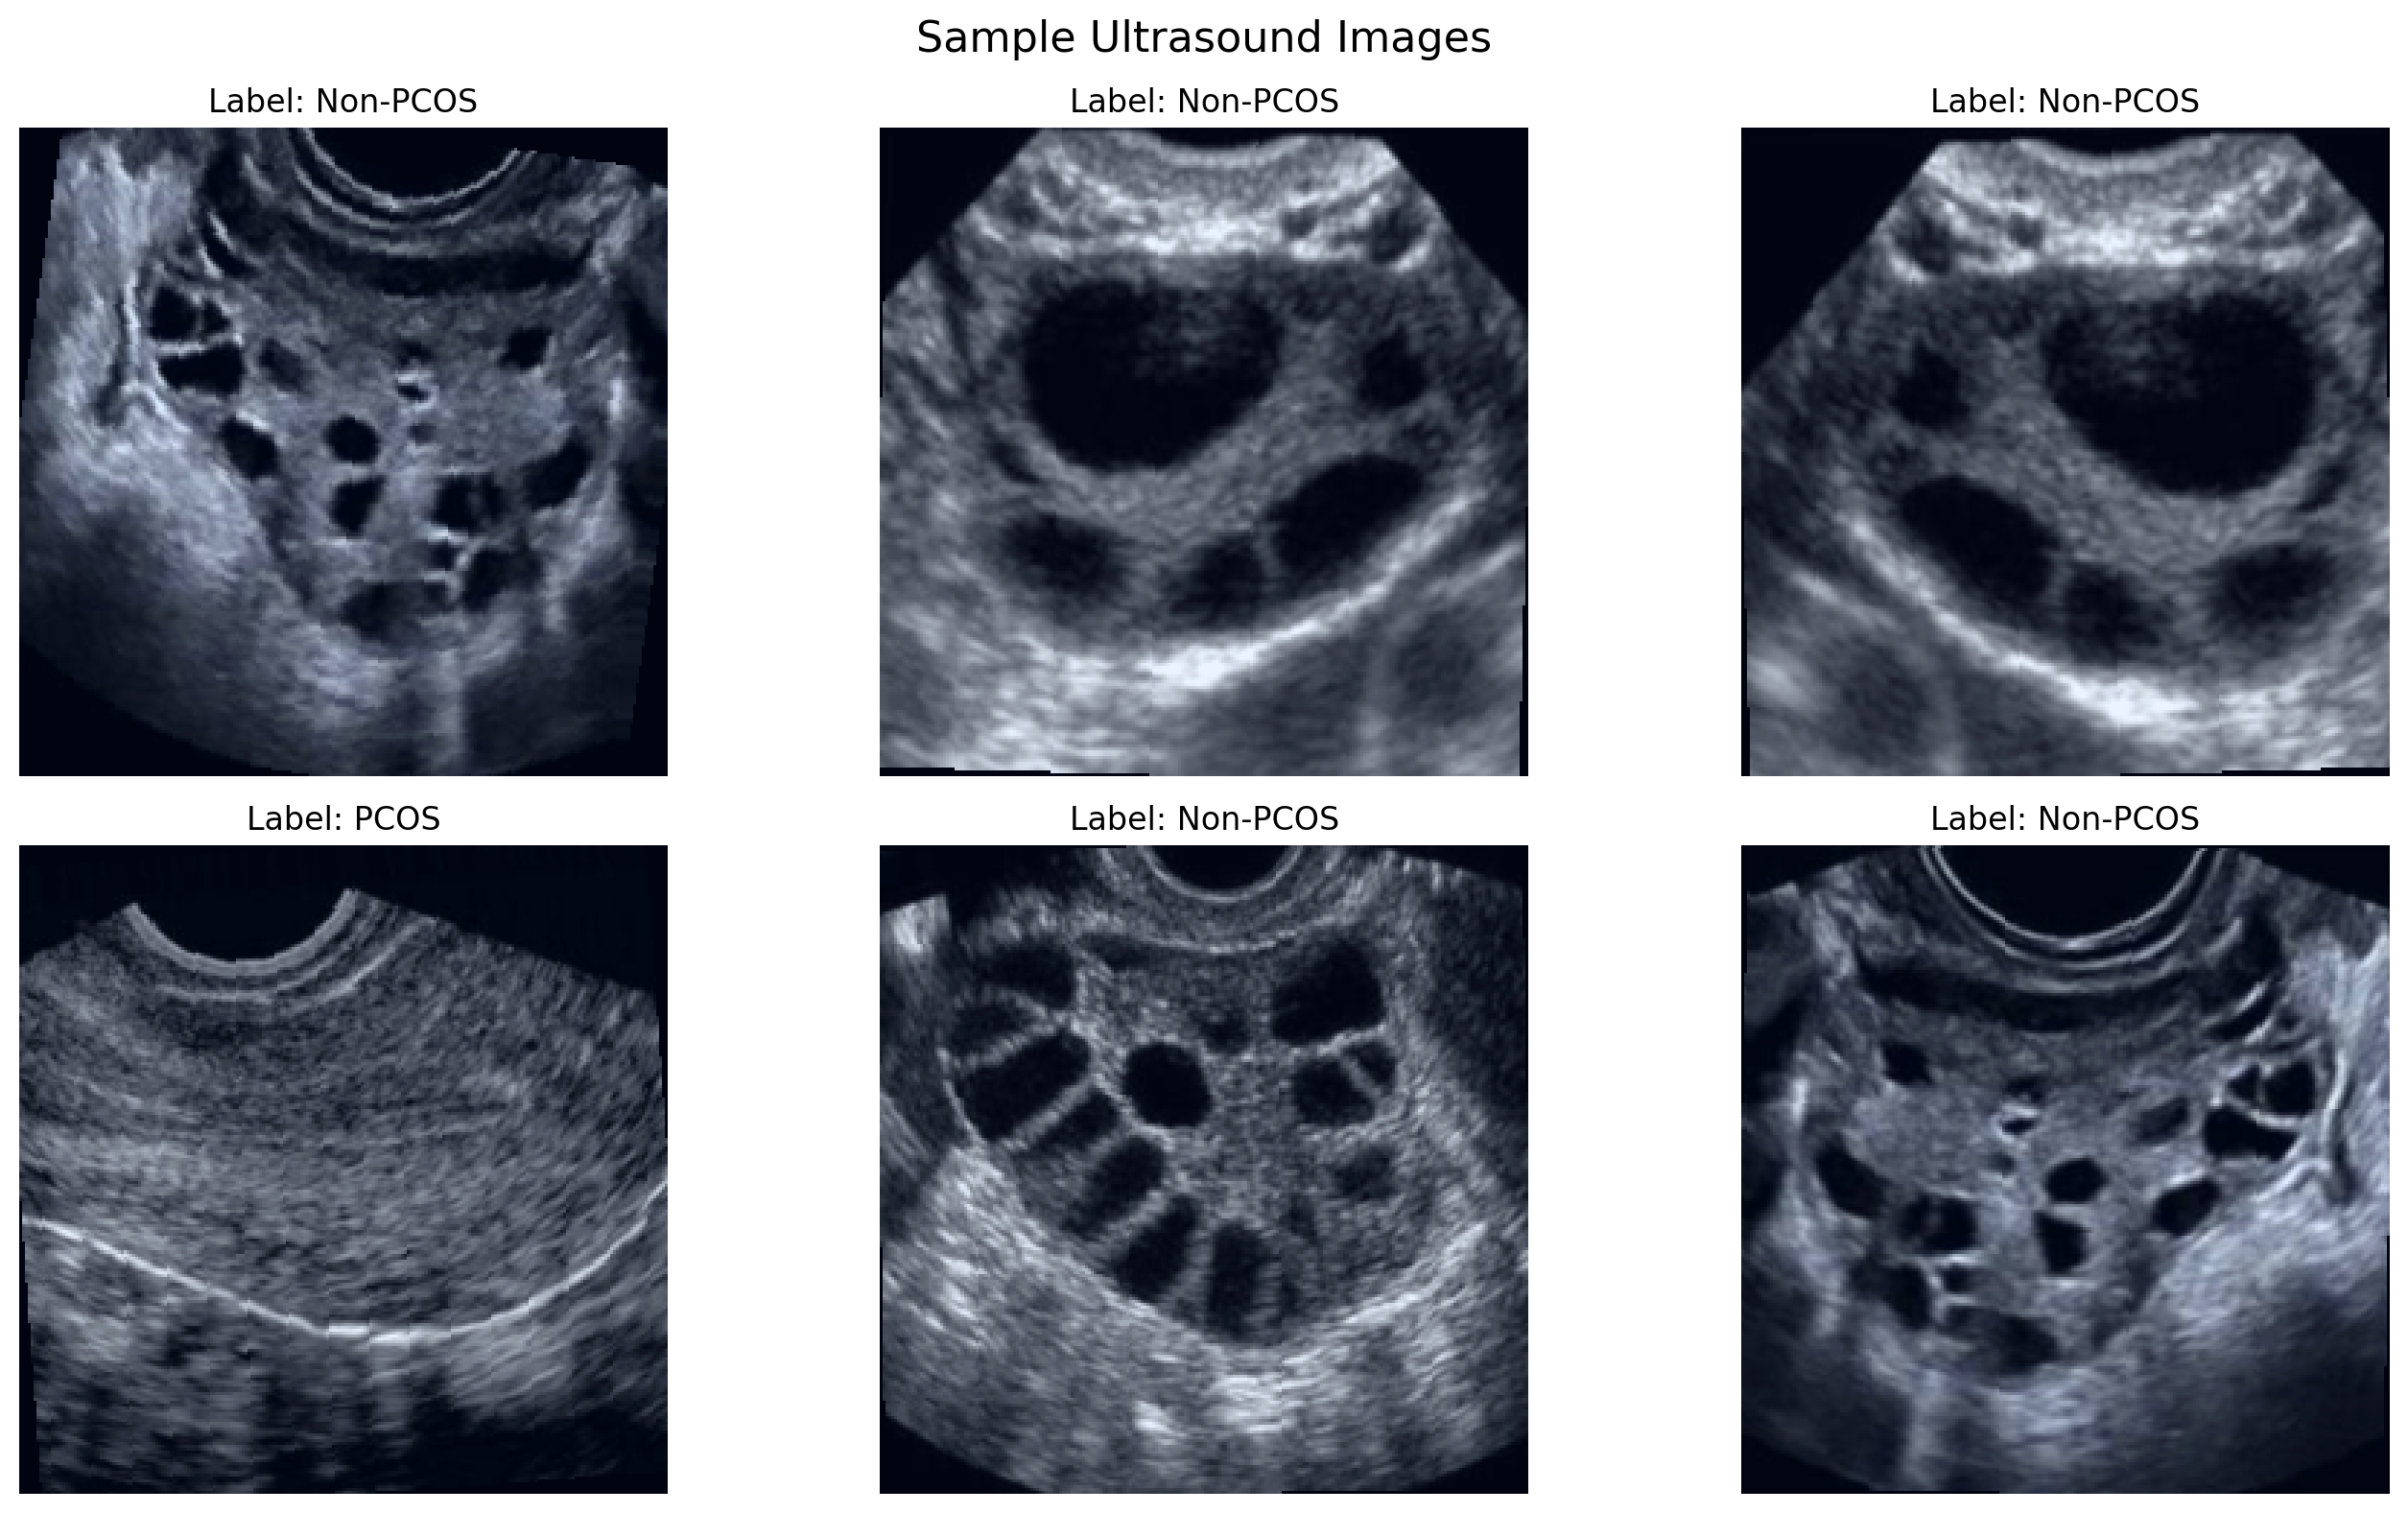

Saved: /content/drive/MyDrive/CSE754/Femnet/output/dataset_samples.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8), dpi=200)

for i in range(6):
    img, _, lbl = train_dataset[i]
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.subplot(2, 3, i+1)
    plt.imshow(img_np)
    plt.title(f"Label: {'PCOS' if int(lbl.item())==1 else 'Non-PCOS'}")
    plt.axis("off")

plt.suptitle("Sample Ultrasound Images", fontsize=16)
plt.tight_layout()

# SAVE
sample_path = os.path.join(output_dir, "dataset_samples.png")
plt.savefig(sample_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", sample_path)


In [ ]:
import matplotlib.pyplot as plt

counts = df["PCOS_Diagnosis"].value_counts()

plt.figure(figsize=(6,5), dpi=200)
plt.bar(["Non-PCOS", "PCOS"], counts.values, color=["steelblue", "tomato"])
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Dataset")
plt.grid(axis="y", alpha=0.3)

# SAVE
class_dist_path = os.path.join(output_dir, "class_distribution.png")
plt.savefig(class_dist_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", class_dist_path)


Saved: /content/drive/MyDrive/CSE754/Femnet/output/class_distribution.png


In [ ]:
epochs = list(range(1, 16))
val_auc = [0.57, 0.63, 0.71, 0.80, 0.87, 0.92, 0.94, 0.95, 0.96, 0.963, 0.964, 0.966, 0.967, 0.971, 0.974]

plt.figure(figsize=(7,5), dpi=200)
plt.plot(epochs, val_auc, marker='o', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Validation AUROC")
plt.title("FEMNET Validation AUROC Curve")
plt.grid(True)

# SAVE
auc_curve_path = os.path.join(output_dir, "femnet_auc_curve.png")
plt.savefig(auc_curve_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", auc_curve_path)


Saved: /content/drive/MyDrive/CSE754/Femnet/output/femnet_auc_curve.png


In [ ]:
plt.figure(figsize=(8,8), dpi=300)
plt.imshow(overlay)
plt.axis("off")
plt.title("FEMNET Grad-CAM Overlay")

gradcam_path = os.path.join(output_dir, "gradcam_overlay.png")
plt.savefig(gradcam_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", gradcam_path)


Saved: /content/drive/MyDrive/CSE754/Femnet/output/gradcam_overlay.png


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, clin, labels in test_loader:
        imgs = imgs.to(device)
        clin = clin.to(device)

        outputs = model(imgs, clin).squeeze()
        preds = torch.sigmoid(outputs).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6), dpi=200)
plt.plot(fpr, tpr, linewidth=2, label=f"FEMNET (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)

roc_path = os.path.join(output_dir, "roc_curve_test.png")
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", roc_path)


Saved: /content/drive/MyDrive/CSE754/Femnet/output/roc_curve_test.png


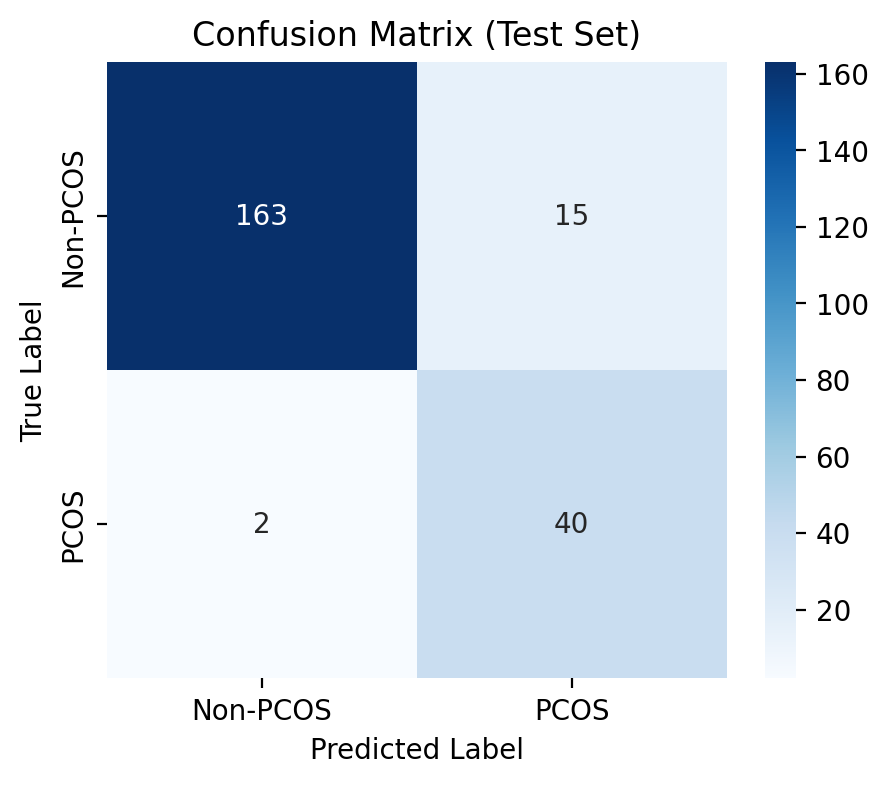

Saved: /content/drive/MyDrive/CSE754/Femnet/output/confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_labels, pred_labels)

plt.figure(figsize=(5,4), dpi=200)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-PCOS", "PCOS"],
            yticklabels=["Non-PCOS", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")

cm_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", cm_path)


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_preds)
ap = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(6,6), dpi=200)
plt.plot(recall, precision, linewidth=2,
         label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)

pr_path = os.path.join(output_dir, "precision_recall_curve.png")
plt.savefig(pr_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", pr_path)


Saved: /content/drive/MyDrive/CSE754/Femnet/output/precision_recall_curve.png


  0%|          | 0/100 [00:00<?, ?it/s]

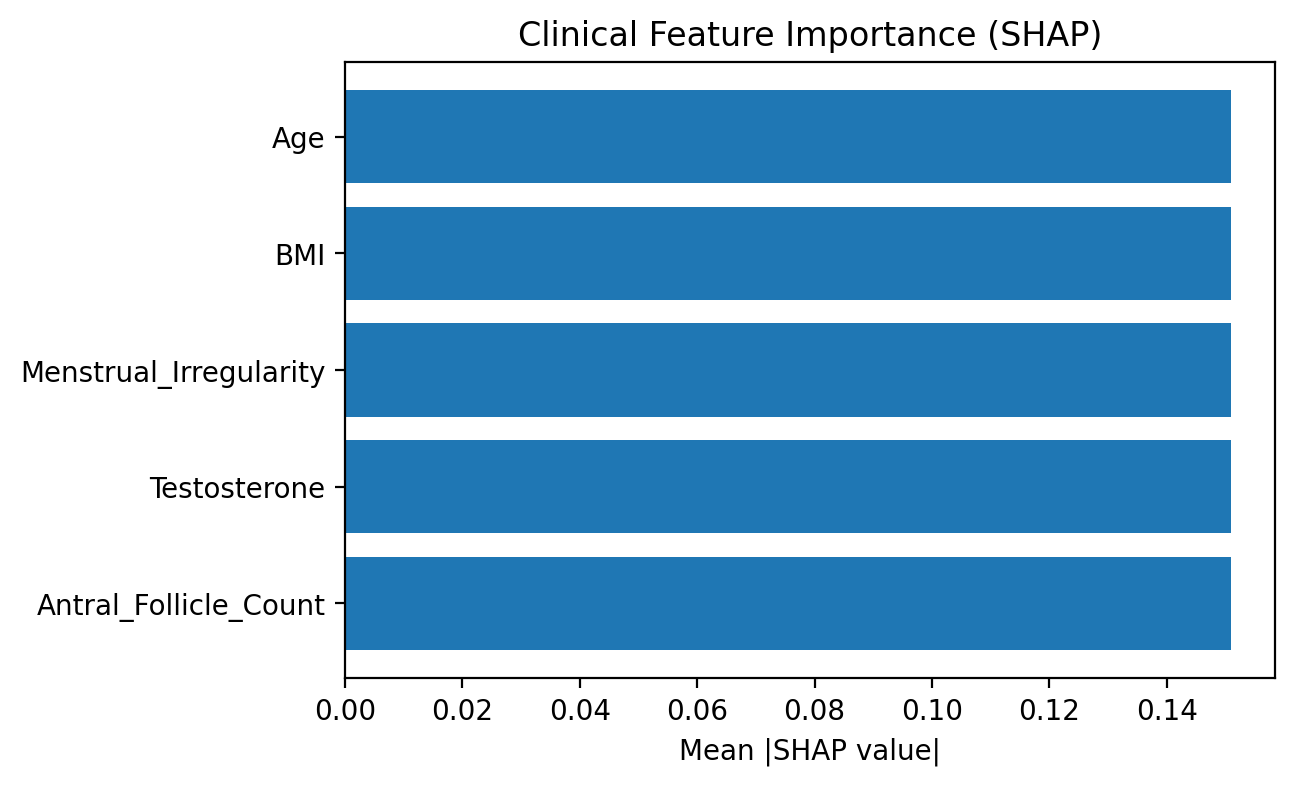

Saved: /content/drive/MyDrive/CSE754/Femnet/output/shap_feature_importance.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Take sufficient samples for stable SHAP
X_shap = test_df[clinical_cols].values[:100].astype("float32")

shap_values = explainer.shap_values(
    X_shap,
    nsamples=200
)

mean_abs_shap = np.mean(np.abs(shap_values[0]), axis=0)

plt.figure(figsize=(6,4), dpi=200)
plt.barh(clinical_feature_names, mean_abs_shap)
plt.xlabel("Mean |SHAP value|")
plt.title("Clinical Feature Importance (SHAP)")
plt.gca().invert_yaxis()

shap_bar_path = os.path.join(output_dir, "shap_feature_importance.png")
plt.savefig(shap_bar_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", shap_bar_path)

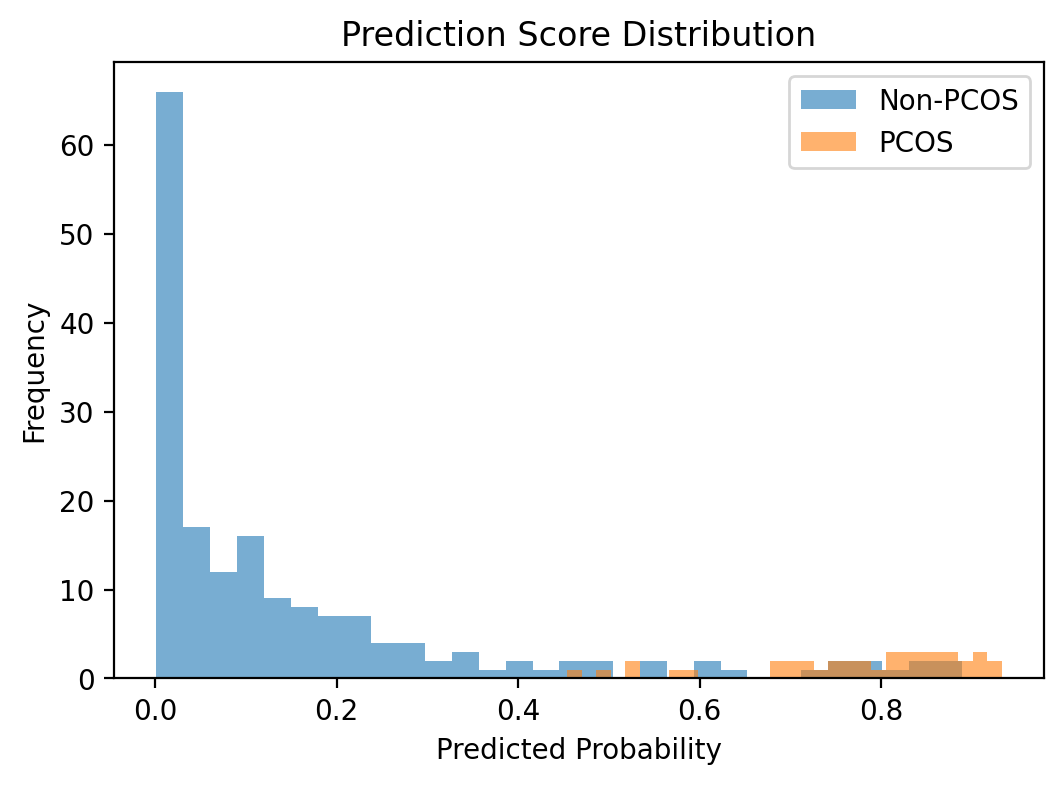

Saved: /content/drive/MyDrive/CSE754/Femnet/output/prediction_score_distribution.png


In [ ]:
plt.figure(figsize=(6,4), dpi=200)
plt.hist(np.array(all_preds)[np.array(all_labels)==0],
         bins=30, alpha=0.6, label="Non-PCOS")
plt.hist(np.array(all_preds)[np.array(all_labels)==1],
         bins=30, alpha=0.6, label="PCOS")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Score Distribution")
plt.legend()

score_path = os.path.join(output_dir, "prediction_score_distribution.png")
plt.savefig(score_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", score_path)


In [ ]:
import os

output_dir = "/content/drive/MyDrive/CSE754/FEMNET_OUTPUT"
os.makedirs(output_dir, exist_ok=True)


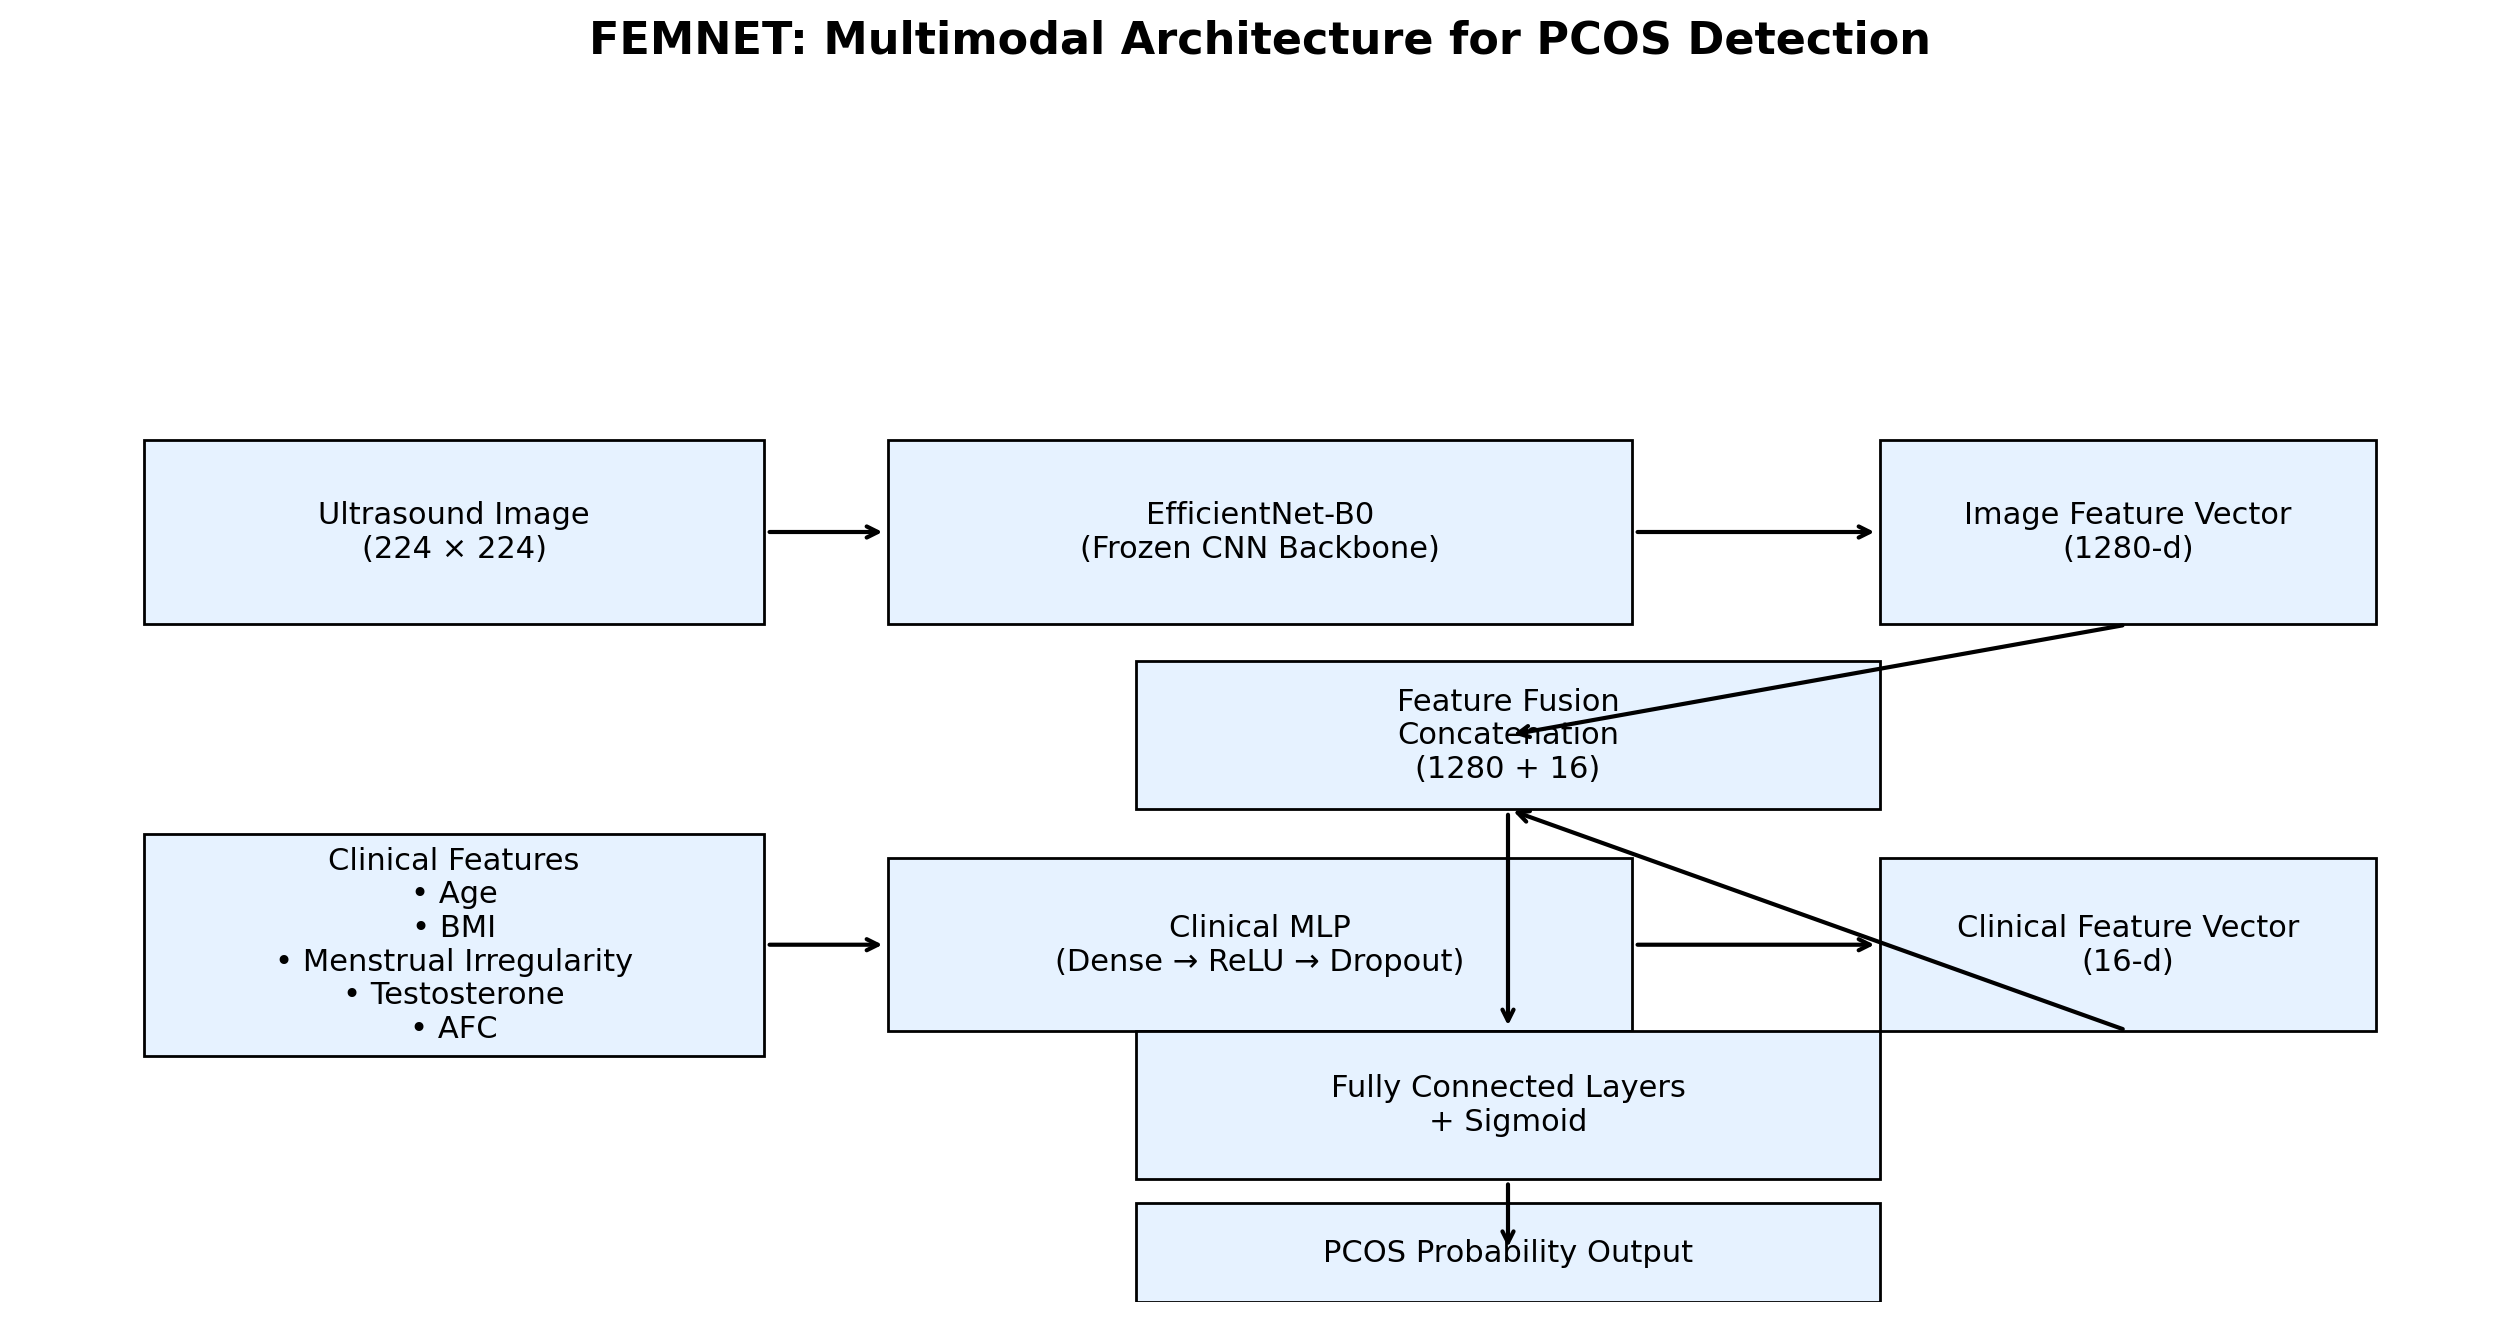

Architecture diagram saved at:
Saved: /content/drive/MyDrive/CSE754/Femnet/output/prediction_score_distribution.png


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

fig, ax = plt.subplots(figsize=(16, 8), dpi=200)
ax.axis("off")

# ---------- Helper function ----------
def draw_box(x, y, w, h, text):
    rect = Rectangle((x, y), w, h, fill=True, edgecolor="black", facecolor="#E6F2FF")
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=11, wrap=True)

def draw_arrow(x1, y1, x2, y2):
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", linewidth=1.5))

# ---------- Image Branch ----------
draw_box(0.05, 0.55, 0.25, 0.15, "Ultrasound Image\n(224 × 224)")
draw_box(0.35, 0.55, 0.30, 0.15, "EfficientNet-B0\n(Frozen CNN Backbone)")
draw_box(0.75, 0.55, 0.20, 0.15, "Image Feature Vector\n(1280-d)")

draw_arrow(0.30, 0.625, 0.35, 0.625)
draw_arrow(0.65, 0.625, 0.75, 0.625)

# ---------- Clinical Branch ----------
draw_box(0.05, 0.20, 0.25, 0.18,
         "Clinical Features\n• Age\n• BMI\n• Menstrual Irregularity\n• Testosterone\n• AFC")

draw_box(0.35, 0.22, 0.30, 0.14,
         "Clinical MLP\n(Dense → ReLU → Dropout)")

draw_box(0.75, 0.22, 0.20, 0.14,
         "Clinical Feature Vector\n(16-d)")

draw_arrow(0.30, 0.29, 0.35, 0.29)
draw_arrow(0.65, 0.29, 0.75, 0.29)

# ---------- Fusion ----------
draw_box(0.45, 0.40, 0.30, 0.12,
         "Feature Fusion\nConcatenation\n(1280 + 16)")

draw_arrow(0.85, 0.55, 0.60, 0.46)
draw_arrow(0.85, 0.22, 0.60, 0.40)

# ---------- Output ----------
draw_box(0.45, 0.10, 0.30, 0.12,
         "Fully Connected Layers\n+ Sigmoid")

draw_arrow(0.60, 0.40, 0.60, 0.22)

draw_box(0.45, 0.00, 0.30, 0.08,
         "PCOS Probability Output")

draw_arrow(0.60, 0.10, 0.60, 0.04)

# ---------- Title ----------
plt.title("FEMNET: Multimodal Architecture for PCOS Detection",
          fontsize=16, weight="bold")

# ---------- Save ----------
arch_path = os.path.join(output_dir, "femnet_architecture_diagram.png")
plt.savefig(arch_path, dpi=300, bbox_inches="tight")
plt.show()

print("Architecture diagram saved at:")
print("Saved:", score_path)



In [ ]:
# Use more samples for visualization
X_shap = test_df[clinical_cols].values[:100].astype("float32")

shap_values = explainer.shap_values(
    X_shap,
    nsamples=200
)


  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 2000x1200 with 0 Axes>

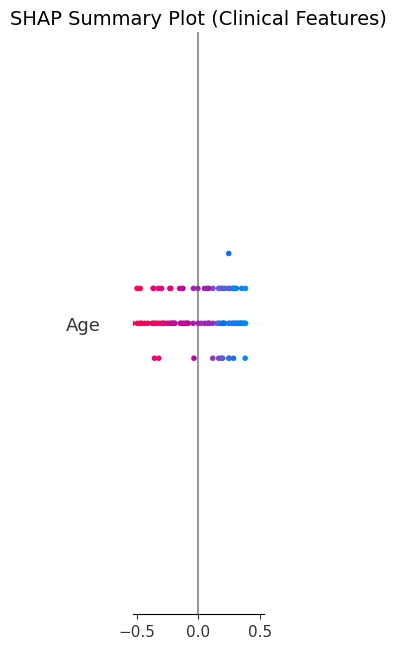

Saved: /content/drive/MyDrive/CSE754/Femnet/output/prediction_score_distribution.png


In [ ]:
import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(10, 6), dpi=200)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clinical_cols,
    show=False,
    plot_size=None
)

plt.title("SHAP Summary Plot (Clinical Features)", fontsize=14)
plt.tight_layout()
plt.show()
print("Saved:", score_path)

<Figure size 1600x1000 with 0 Axes>

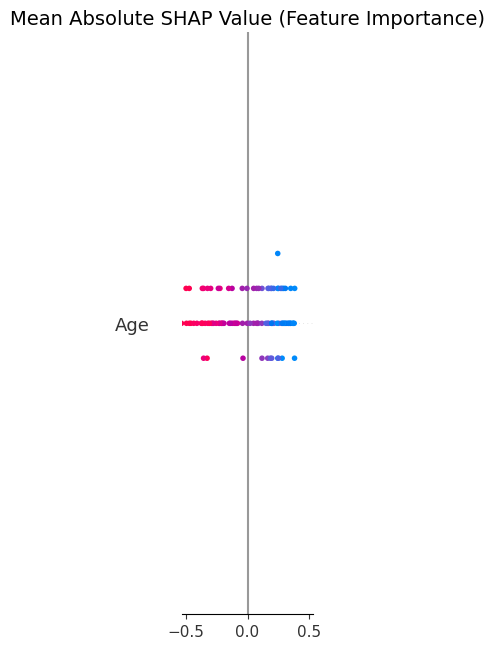

Saved: /content/drive/MyDrive/CSE754/Femnet/output/prediction_score_distribution.png


In [ ]:
plt.figure(figsize=(8, 5), dpi=200)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clinical_cols,
    plot_type="bar",
    show=False
)

plt.title("Mean Absolute SHAP Value (Feature Importance)", fontsize=14)
plt.tight_layout()
plt.show()
print("Saved:", score_path)

In [ ]:
plt.figure(figsize=(8, 5), dpi=200)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clinical_cols,
    plot_type="bar",
    show=False
)

plt.title("Mean Absolute SHAP Value (Feature Importance)", fontsize=14)
plt.tight_layout()
plt.show()
print("Saved:", score_path)

<Figure size 1600x1000 with 0 Axes>

Saved: /content/drive/MyDrive/CSE754/Femnet/output/prediction_score_distribution.png


In [ ]:
# Take sufficient samples for stable SHAP
X_shap = test_df[clinical_cols].values[:100].astype("float32")

shap_values = explainer.shap_values(
    X_shap,
    nsamples=200
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(9, 5), dpi=200)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clinical_cols,
    plot_type="bar",
    show=False
)

plt.title("Clinical Feature Importance using SHAP (FEMNET)", fontsize=14)
plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

<Figure size 2700x1500 with 0 Axes>

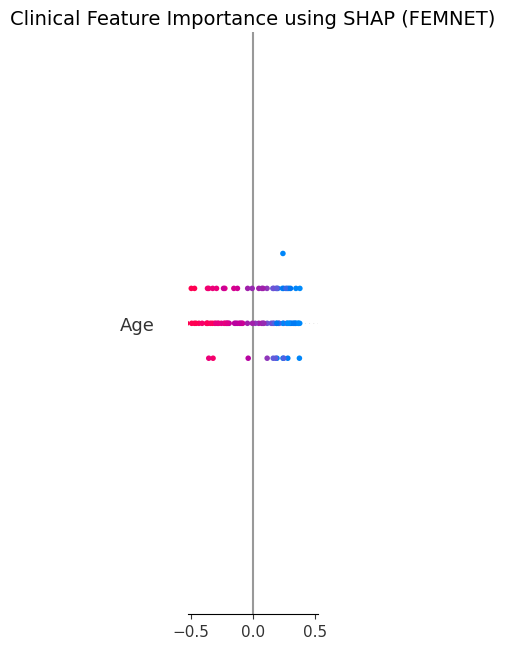

Saved SHAP bar plot at: /content/drive/MyDrive/CSE754/FEMNET_OUTPUT/shap_feature_importance_bar.png


In [ ]:
import os

shap_bar_path = os.path.join(output_dir, "shap_feature_importance_bar.png")
plt.figure(figsize=(9, 5), dpi=300)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clinical_cols,
    plot_type="bar",
    show=False
)

plt.title("Clinical Feature Importance using SHAP (FEMNET)", fontsize=14)
plt.tight_layout()
plt.savefig(shap_bar_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved SHAP bar plot at:", shap_bar_path)
